In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from pyclustertend import hopkins
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [37]:
!pip install --user pyclustertend

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

yellowbrick 1.4 requires scikit-learn>=1.0.0, but you'll have scikit-learn 0.24.2 which is incompatible.



  Using cached pyclustertend-1.7.0-py3-none-any.whl (7.2 kB)
  Using cached numba-0.54.1-cp38-cp38-win_amd64.whl (2.3 MB)
  Using cached scikit_learn-0.24.2-cp38-cp38-win_amd64.whl (6.9 MB)
  Using cached matplotlib-3.5.2-cp38-cp38-win_amd64.whl (7.2 MB)
  Using cached llvmlite-0.37.0-cp38-cp38-win_amd64.whl (17.0 MB)
  Using cached fonttools-4.33.3-py3-none-any.whl (930 kB)


In [4]:
#!pip install yellowbrick

  Using cached yellowbrick-1.4-py3-none-any.whl (274 kB)


<h1>Functions</h1>

In [2]:
def normalization(df):
    df_norm_minmax = minmax_scaler.fit_transform(df.values)
    ndf = pd.DataFrame(df_norm_minmax, columns=df.columns)
    return ndf

In [3]:
def Elbow_vis(ndf):
    k_max =15
    model = KMeans()
    vis = KElbowVisualizer(model, k=(2,k_max), metric='distortion', timings=False)
    vis.fit(ndf)  
    vis.show()

In [4]:
def Silhoulette_vis(ndf):
    k_max =15
    model = KMeans()
    vis = KElbowVisualizer(model, k=(2,k_max), metric='silhouette', timings=False)
    vis.fit(ndf)  
    vis.show()

In [5]:
def Elbow_Method(ndf):
    distortions = []
    max_k = 15
    for k in range(2, max_k):
        kmeans_iter = KMeans(n_clusters=k, n_init=10, max_iter=100)
        kmeans_iter.fit(ndf)
    
        distortions.append(kmeans_iter.inertia_)
        
    return distortions

In [6]:
def K_Silhoulette(ndf):
    sil_list = list()
    max_k = 15
    for k in range(2, max_k):
        kmeans_iter = KMeans(n_clusters=k, n_init=10, max_iter=100)
        kmeans_iter.fit(ndf)
    
        sil_list.append(silhouette_score(ndf, kmeans_iter.labels_))
        
    return sil_list
    

In [7]:
def K_Means(k,ndf,df,sil_list):
    labels = []
    centers=[]
    kmeans = KMeans(n_clusters=k, n_init=100)
    kmeans.fit(ndf)
    centers.append(minmax_scaler.inverse_transform(kmeans.cluster_centers_)) # we store the coordinates of the centroids
    labels.append(kmeans.labels_) # we store the labels associated with the records
    print("SILHOUETTE:",sil_list[k-2])
    
    cluster_col = 'K_' + str(k) # it contains the name of the column containing the optimal labels
    #l = np.transpose(labels)
    #df[cluster_col] = l
    [centers]=centers
    
    return labels,centers,cluster_col

In [8]:
def ConvertClusterList(df,k_str):
    clust_list = list()
    for i in range(len(df[k_str].unique())):
        clust_list.append(df[df[k_str] == i])
        
    return clust_list

In [9]:
def plot_elbow(distortions):
    # plot indicators
    plt.figure(figsize=(12, 8))
    plt.plot(range(2, len(distortions) + 2), distortions)
    plt.xlabel('K', fontsize=20)
    plt.ylabel('Distortions', fontsize=18)
    plt.legend()
    plt.show()

In [10]:
def plot_silhoulette(sil_list):
    # plot indicators
    plt.figure(figsize=(12, 8))
    plt.plot(range(2, len(sil_list) + 2), sil_list)
    plt.xlabel('K', fontsize=20)
    plt.ylabel('Silhouette', fontsize=18)
    plt.legend()
    plt.show()

In [11]:
def plot_silhoulette_clusters(ndf,labels,k):
    plt.figure(figsize = (12,6))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    plt.xlim([-0.1, 1])
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(ndf) + (k + 1) * 10])
    
    silhouette_avg = silhouette_score(ndf, labels)
    sample_silhouette_values = silhouette_samples(ndf, labels)

    y_lower = 10
    bar_colors = []
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.cividis(float(i) / k)
        bar_colors.append(color)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters. Avg Sil = " + '{:.4f}'.format(silhouette_avg))
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

In [12]:
def plot_parallelCoordinates(centers,df):
    plt.figure(figsize=(28, 10))
    for i in range(0, len(centers)):
        plt.plot(centers[i], marker='o', label='Cluster %s' % i)
    plt.tick_params(axis='both', which='major', labelsize=5)
    plt.xticks(range(0, len(df.columns)), df.columns, fontsize=15)
    plt.legend(fontsize=10)
    plt.show()

In [13]:
def plot_Histograms(df,clust_list):
    attr = df.columns[:-1]
    num_elements = 4
    clusters = range(len(clust_list))
    fig, axs = plt.subplots(math.ceil(len(attr) / num_elements),num_elements,figsize=(15,15))
    for attr_index in range(len(attr)):
        mean_values = []
        for cluster_df in clust_list:
            mean_values.append(cluster_df.describe()[attr[attr_index]][1])
        axs[int(attr_index / num_elements)][attr_index % num_elements].bar(clusters, mean_values, color = ['b','y','g','r'])
        axs[int(attr_index / num_elements)][attr_index % num_elements].set_title(f"{attr[attr_index]} - Mean")

In [14]:
def plot_Scatter3D(pca_customer):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    scatter=ax.scatter(pca_customer[:,0],pca_customer[:,1],pca_customer[:,2], c=clusters_customers.labels_,s=40,alpha=0.7)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    legend= ax.legend(*scatter.legend_elements(),loc="lower right", title="Clusters:")
    ax.add_artist(legend)

    plt.show()

In [15]:
def plot_ExplaneidVariancePCA(customer):
    scaler = StandardScaler()
    std_customer = scaler.fit_transform(customer)

    pca = PCA()
    pca.fit(std_customer)

    plt.step(range(1, customer.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), where='mid', label='Cumulative Explained Variance')
    plt.bar(range(1, customer.shape[1] + 1), pca.explained_variance_ratio_, alpha=0.4, color='g', label='Individual Explained Variance')

    plt.ylabel('Explained Variance')
    plt.xlabel('Principal Components')
    plt.legend(loc='center right');
    return std_customer

<h1>Customer 2009</h1>

In [18]:
# Starting dataset
df = pd.read_csv('dataset/Customer_2009_subset.csv', sep=',', index_col=0)
df

,avgSpent,Nsessions,avgItemSession
Customer ID,,,
12346.0,3.800,5,5.2
12358.0,35.890,1,91.0
12359.0,48.570,2,97.0
12417.0,23.575,2,74.5
12422.0,6.650,1,60.0
...,...,...,...
18268.0,37.170,1,142.0
18271.0,26.550,1,44.0
18275.0,20.650,1,128.0


<h3>Correlation Matrix</h3>

<p>We begin by examining the correlations between the attributes of the dataset to be clustered in order to identify the highly correlated couples.
Dropping redundant attributes benefits the analysis by reducing the dimensionality of the dataset and rising the influence that more useful feature could have on the whole clustering process</p>

In [31]:
mat = df.corr()

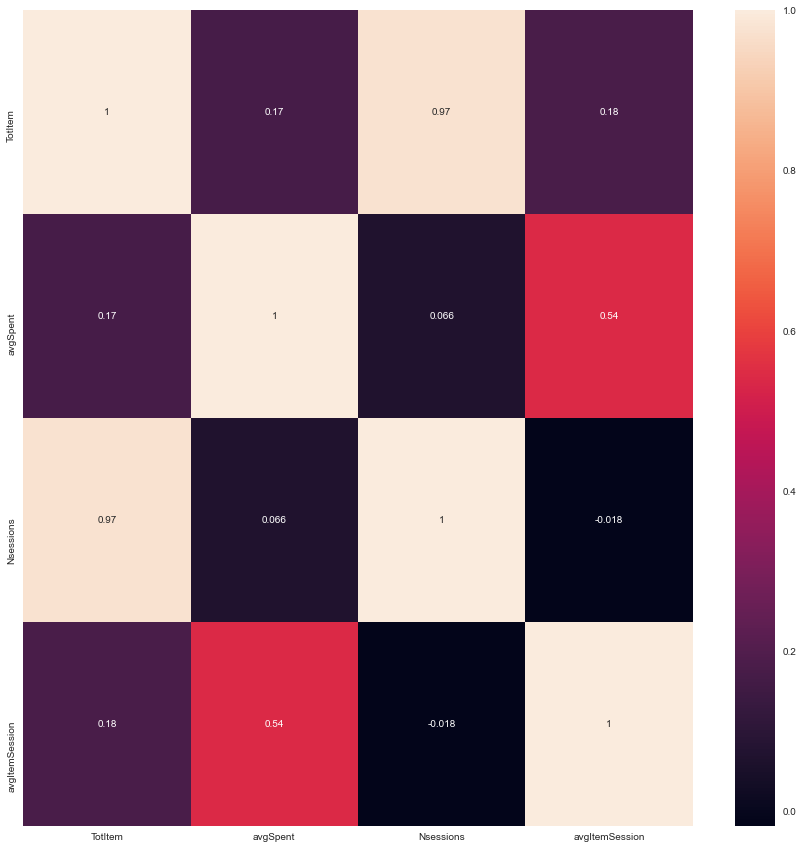

In [32]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(mat, annot=True)
plt.show()

<p>We fix a maximum threshold value in order to identify highly correlated features and subsequently drop them</p>

In [30]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df.columns)):
    for j in range(i+1, len(df.columns)):
        corr = df[df.columns[i]].corr(df[df.columns[j]])
        if  corr > corr_threshold:
            print(df.columns[i] + "\t" + df.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
TotItem	Nsessions	0.9722


<p>As a result of this analysis we decide to eliminate the attribute avgSpentMonth, MeanItemMonth and NSessionsMonth

Despite the high correlation among the others attributes we decide not to eliminate either of them due to their relevance within the whole grouping process.</p>

In [34]:
corr_columns = ['avgSpentMonth','MeanItemMonth','NSessionsMonth','Min','Max','MaxItem','MinItem','DistinctItem','TotSpent','MeanTimeGap','MaxSessionsMonth'
               ,'TotItem']
df.drop(corr_columns, axis=1, inplace=True)

In [36]:
df.to_csv('dataset/Customer_2009_subset.csv')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 909 entries, 12346.0 to 18286.0
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   avgSpent        909 non-null    float64
 1   Nsessions       909 non-null    int64  
 2   avgItemSession  909 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 28.4 KB


In [41]:
df = pd.read_csv('dataset/Customer_2009_subset_preproc.csv', sep=',', index_col=0)

<h3>Hopkins test</h3>

In [19]:
hopkins(df,len(df))

0.03504286116014249

<p>The data are not uniformly distributed. Hence clustering can be useful to classify the observations.</p>

<h3>Normalization</h3>

<p>Normalization of data to avoid the dominance - bias- of attributes with an higher magnitude with respect to others.</p>

In [20]:
minmax_scaler = MinMaxScaler()
ndf=normalization(df)

<h2>K-MEANS</h2>

<p>Run K-Means for values of K in range 2-15 in order to find the best value.
    
The analysis to determine the number of cluster is based on elbow method and average silhouette coeffincent indicator.
</p>

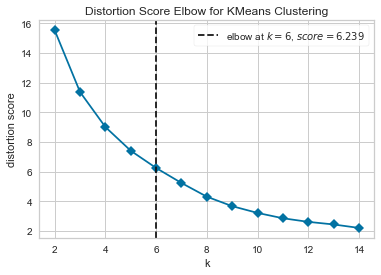

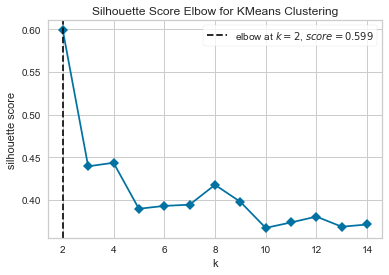

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


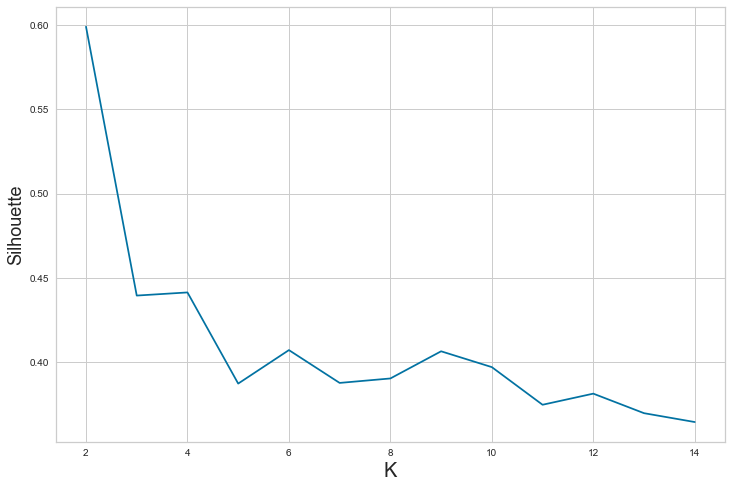

In [21]:
#distortions_09=Elbow_Method(ndf)
Elbow_vis(ndf)
sil_list_09=K_Silhoulette(ndf)
Silhoulette_vis(ndf)
#plot_elbow(distortions_09)
plot_silhoulette(sil_list_09)

<h2>Analysis of cluster</h2>

In [22]:
k_list=[2,3,4,5]
labels_k=[]
centers_k=[]
cluster_col_k=[]

for i in k_list:
    labels,centers,cluster_col=K_Means(i,ndf,df,sil_list_09)
    labels_k.append(labels)
    centers_k.append(centers)
    cluster_col_k.append(cluster_col)
    
#labels,centers,cluster_col=K_Means(2,ndf_10,df_10,sil_list_10)

SILHOUETTE: 0.5989304126143176
SILHOUETTE: 0.4395702482794632
SILHOUETTE: 0.44142398248539766
SILHOUETTE: 0.38739951413627427


In [23]:
clust_list_09_k=[]
for i in range(0,len(k_list)):
    data=df.copy()
    l = np.transpose(labels_k[i])
    data[cluster_col_k[i]]=l
    clust_list_09=ConvertClusterList(data,cluster_col_k[i])
    clust_list_09_k.append(clust_list_09)
    del data

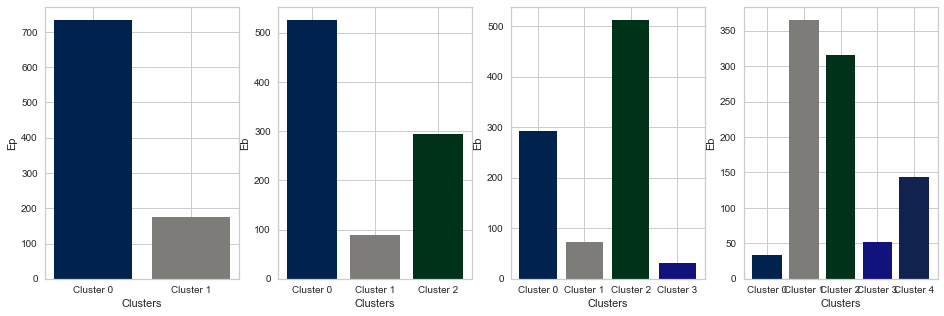

In [24]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

axs[0].bar(['Cluster 0','Cluster 1'], [len(clust_list_09_k[0][0]), len(clust_list_09_k[0][1])], color=['#00224e','#7d7c78'])
axs[0].set_xlabel('Clusters')
axs[0].set_ylabel('Ep')
#axs[0].set_title('Ep of the centroids of the clusters')

axs[1].bar(['Cluster 0','Cluster 1','Cluster 2'], [len(clust_list_09_k[1][0]),len(clust_list_09_k[1][1]),len(clust_list_09_k[1][2])], color=['#00224e','#7d7c78','#00321a'])
axs[1].set_xlabel('Clusters')
axs[1].set_ylabel('Eb')

axs[2].bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3'], [len(clust_list_09_k[2][0]),len(clust_list_09_k[2][1]),len(clust_list_09_k[2][2]),len(clust_list_09_k[2][3])], color=['#00224e','#7d7c78','#00321a','#11127c'])
axs[2].set_xlabel('Clusters')
axs[2].set_ylabel('Eb')

axs[3].bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'], [len(clust_list_09_k[3][0]),len(clust_list_09_k[3][1]),len(clust_list_09_k[3][2]),len(clust_list_09_k[3][3]),len(clust_list_09_k[3][4])], color=['#00224e','#7d7c78','#00321a','#11127c','#11224e'])
axs[3].set_xlabel('Clusters')
axs[3].set_ylabel('Eb')
#axs[1].set_title('Eb of the centroids of the clusters')

#plt.suptitle(("Analysis of the influence of Ep and Eb within the clustering process"),
     #        fontsize=16, fontweight='bold')
plt.show()

<p>With the elbow rule and looking at the graphs we see that the best value of K is 4</p>

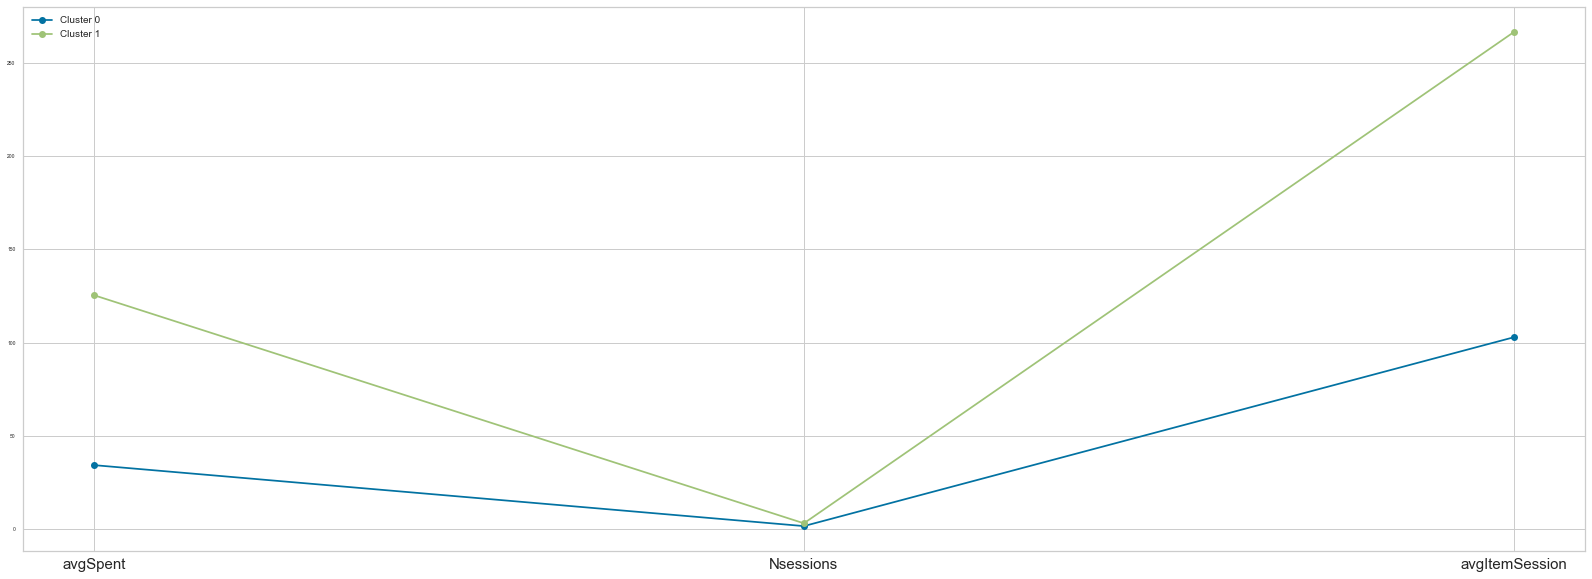

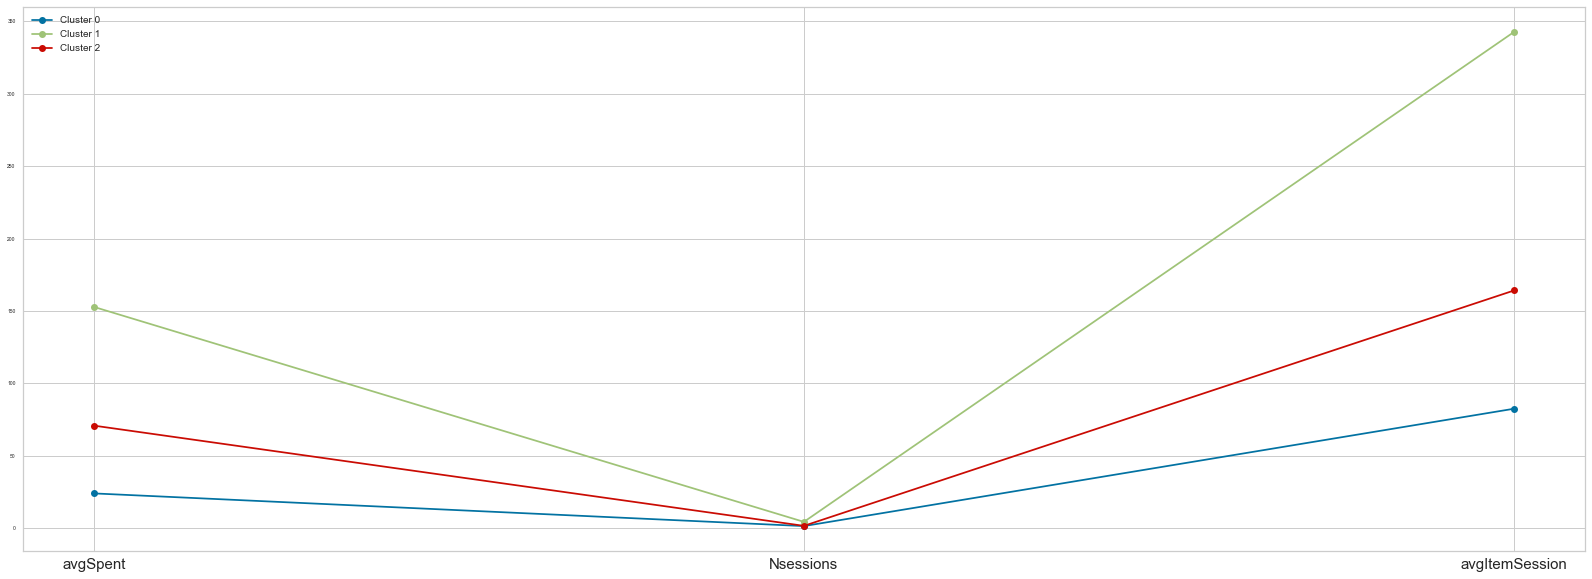

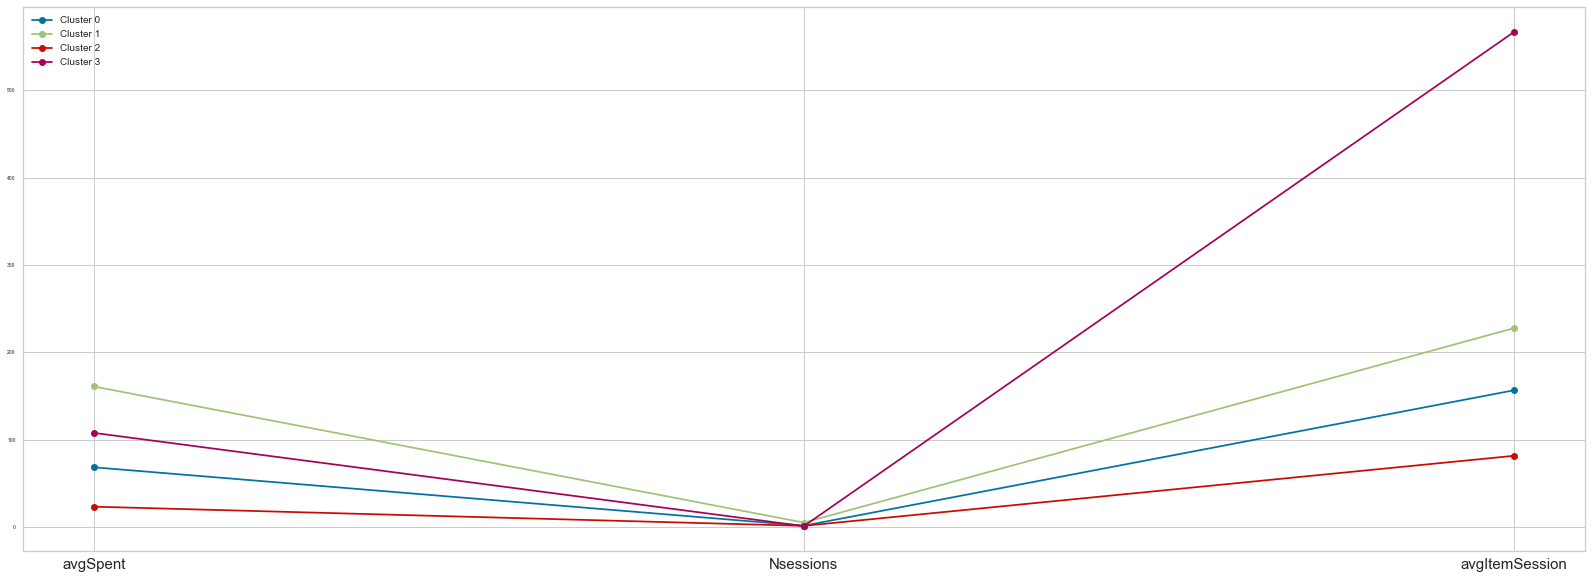

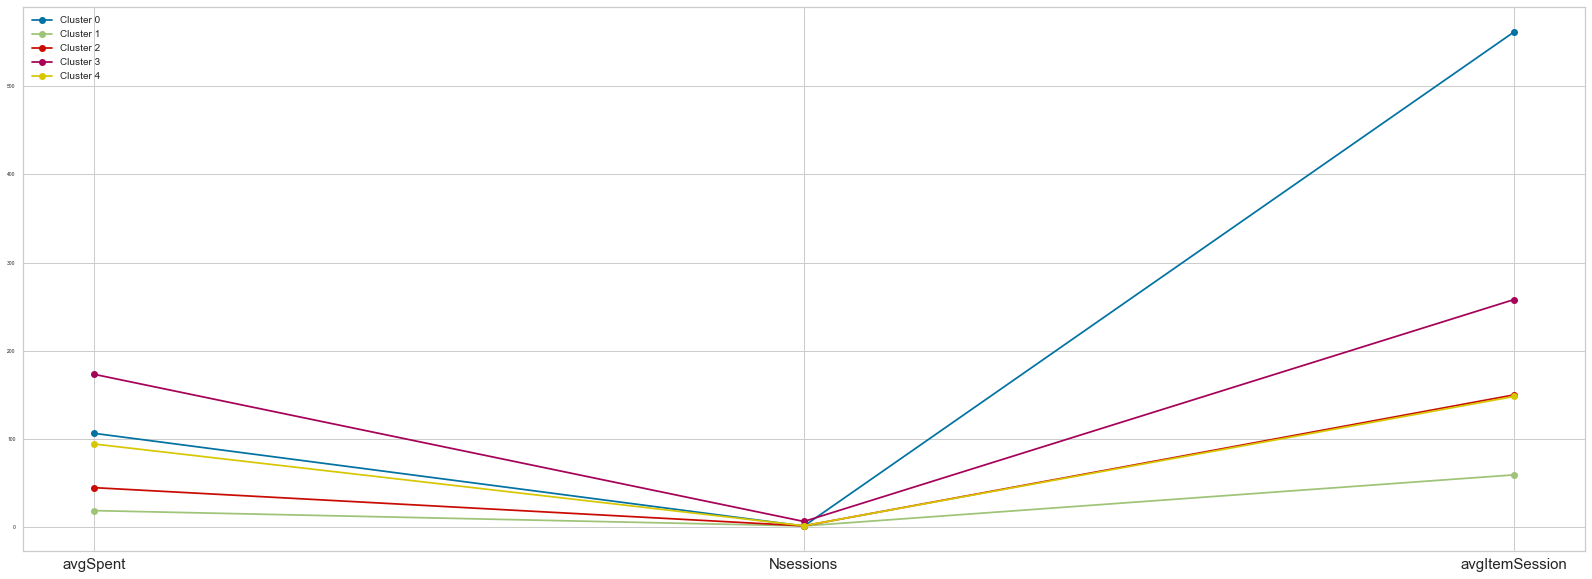

In [25]:
 for i in range(0,len(k_list)):
    plot_parallelCoordinates(centers_k[i],df)

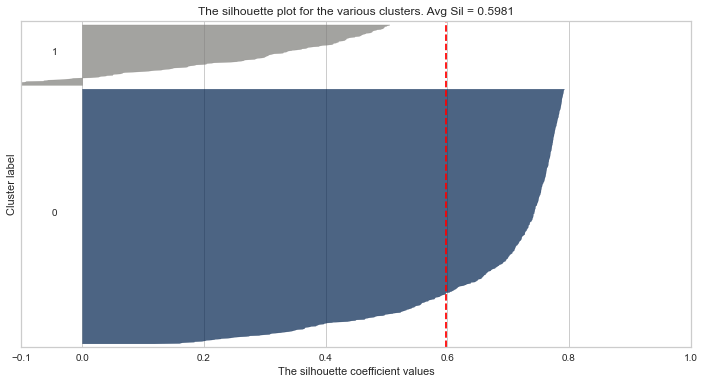

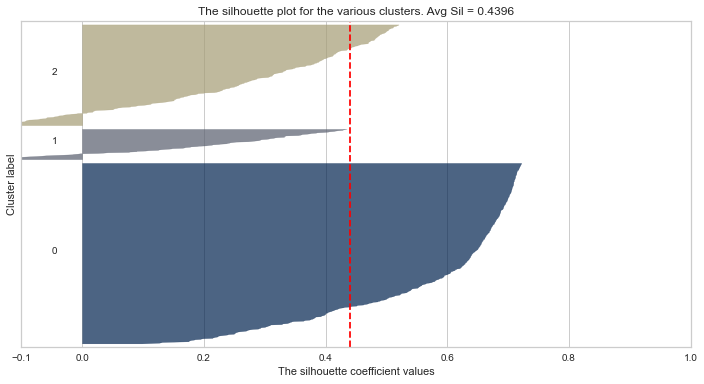

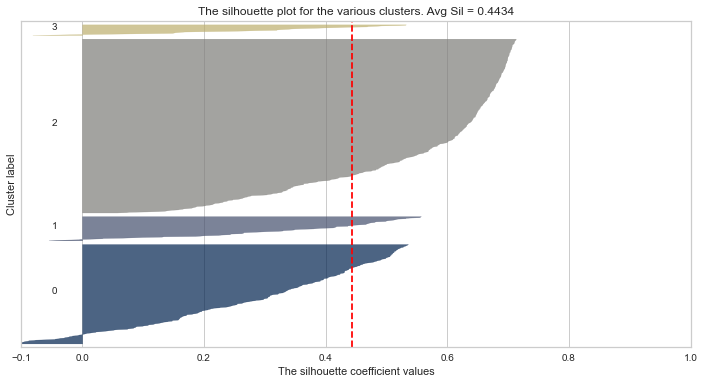

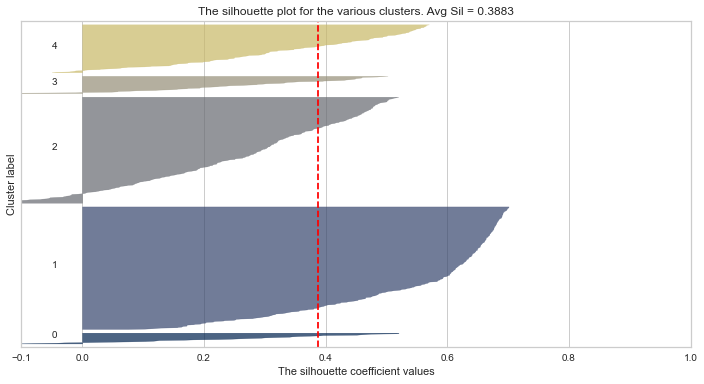

In [26]:
for i in k_list:
    labels_opt=labels_k[i-2]
    [labels_opt]=labels_opt
    plot_silhoulette_clusters(ndf,labels_opt,i)

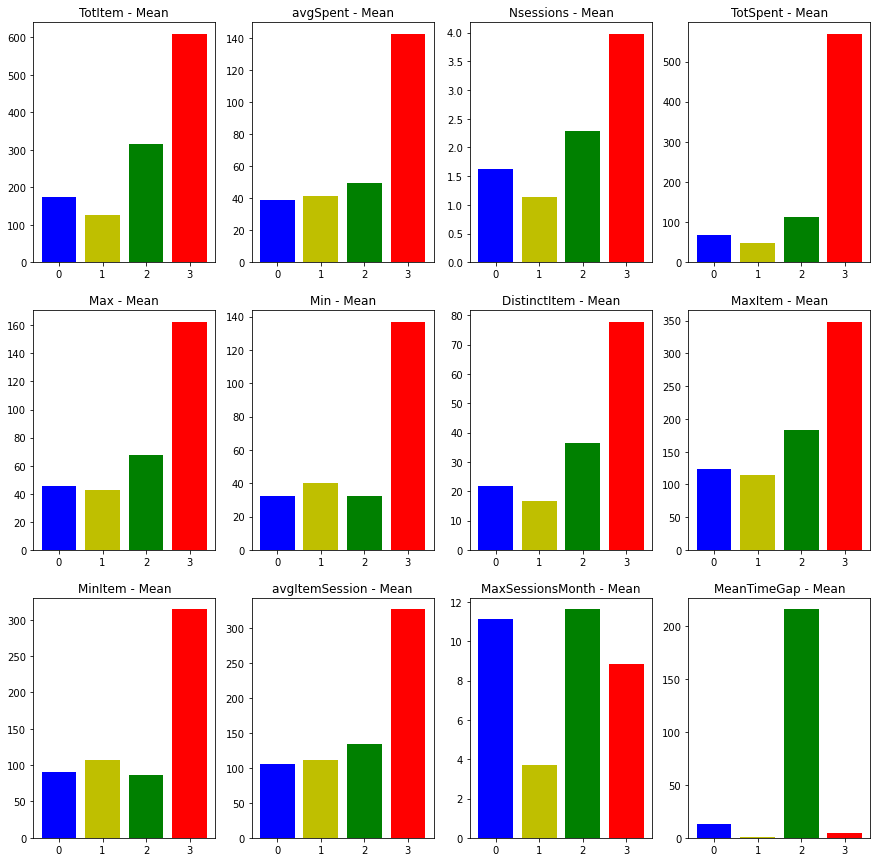

In [20]:
plot_Histograms(df,clust_list)

<h2>Dimensionality Reduction using PCA</h2>

In [21]:
customer=df

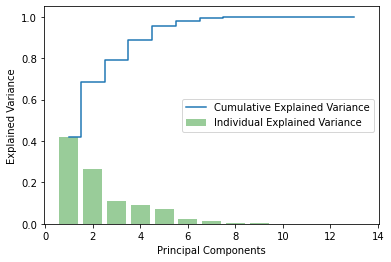

In [24]:
std_customer=plot_ExplaneidVariancePCA(customer)

In [25]:
pca = PCA(n_components=3)
pca_customer = pca.fit_transform(std_customer)

No handles with labels found to put in legend.


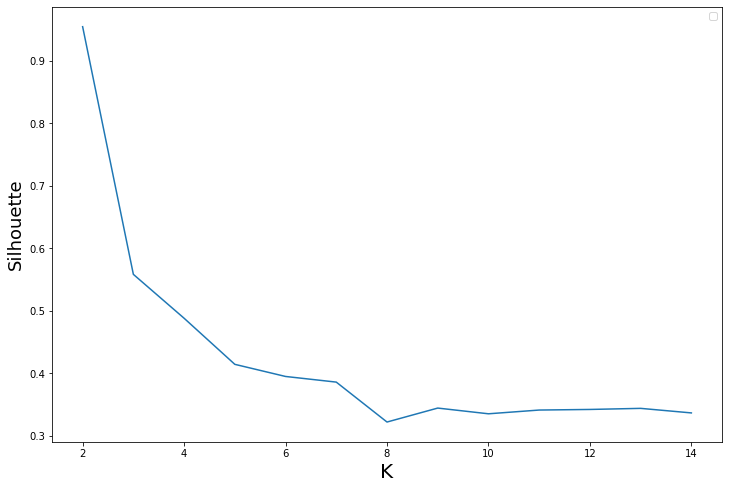

In [26]:
sil_list_pca_09=K_Silhoulette(pca_customer)
plot_silhoulette(sil_list_pca_09)

In [28]:
kmeans = KMeans(n_clusters=4, n_init=100)
clusters_customers = kmeans.fit(pca_customer)

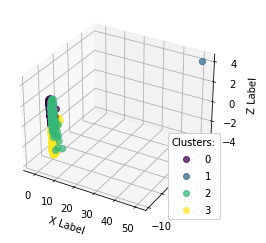

In [29]:
plot_Scatter3D(pca_customer)

In [33]:
cont=0
for i in range(0,len(clusters_customers.labels_)):
    if clusters_customers.labels_[i] == 3:
        break;
    cont=cont+1
    
df.iloc[cont]

TotItem             23408.000000
avgSpent              141.860876
Nsessions             274.000000
TotSpent            38869.880000
Max                  1699.900000
Min                     0.000000
DistinctItem         1990.000000
MaxItem              1068.000000
MinItem                 1.000000
avgItemSession         85.430657
MaxSessionsMonth       12.000000
MeanTimeGap             1.650718
Name: 17841.0, dtype: float64

<h1>Customer 2010</h1>

In [20]:
# Starting dataset
df_10 = pd.read_csv('dataset/Customer_2010.csv', sep=',', index_col=0)
#df_10 = pd.read_csv('dataset/Customer_2010_subset_preproc.csv', sep=',', index_col=0)


In [21]:
mat = df_10.corr()

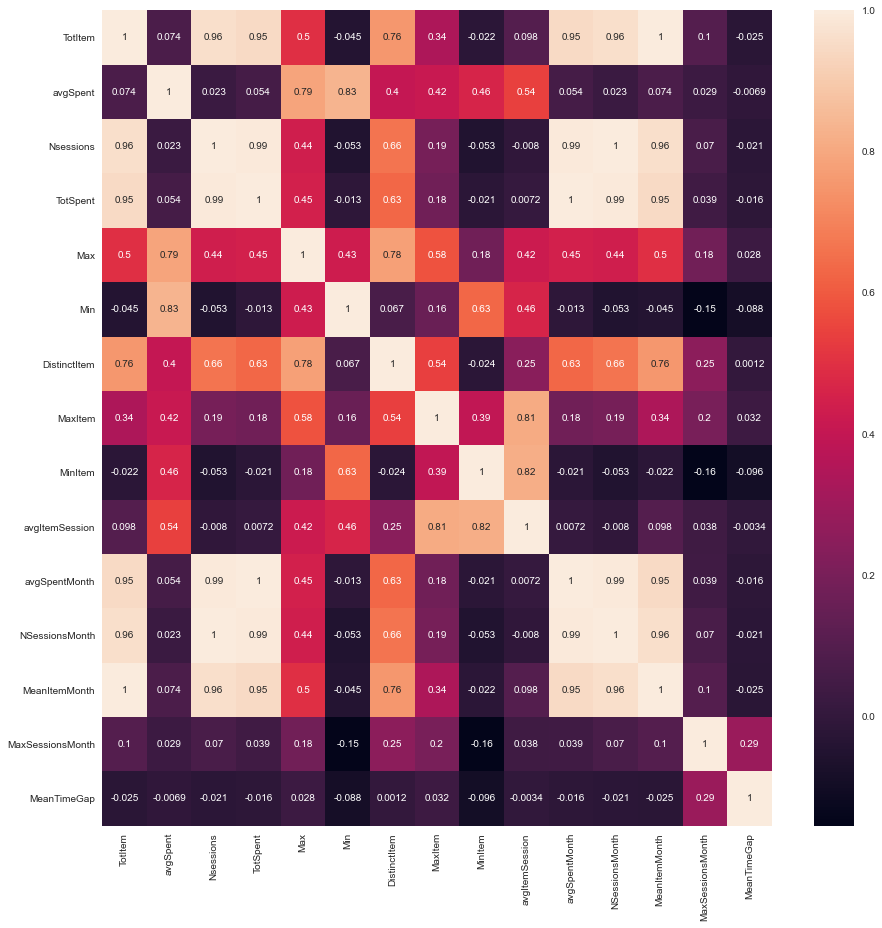

In [22]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(mat, annot=True)
plt.show()

In [23]:
corr_threshold = 0.8
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df_10.columns)):
    for j in range(i+1, len(df_10.columns)):
        corr = df_10[df_10.columns[i]].corr(df_10[df_10.columns[j]])
        if  corr > corr_threshold:
            print(df_10.columns[i] + "\t" + df_10.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
TotItem	Nsessions	0.9637
TotItem	TotSpent	0.9465
TotItem	avgSpentMonth	0.9465
TotItem	NSessionsMonth	0.9637
TotItem	MeanItemMonth	1.0000
avgSpent	Min	0.8336
Nsessions	TotSpent	0.9924
Nsessions	avgSpentMonth	0.9924
Nsessions	NSessionsMonth	1.0000
Nsessions	MeanItemMonth	0.9637
TotSpent	avgSpentMonth	1.0000
TotSpent	NSessionsMonth	0.9924
TotSpent	MeanItemMonth	0.9465
MaxItem	avgItemSession	0.8060
MinItem	avgItemSession	0.8159
avgSpentMonth	NSessionsMonth	0.9924
avgSpentMonth	MeanItemMonth	0.9465
NSessionsMonth	MeanItemMonth	0.9637


In [19]:
#corr_columns = ['avgSpentMonth','MeanItemMonth','NSessionsMonth','Min','Max','MaxItem','MinItem','DistinctItem','TotSpent','MeanTimeGap','MaxSessionsMonth'
              # ,'TotItem']

corr_columns = ['TotItem','MeanItemMonth','NSessionsMonth','avgSpentMonth','MaxItem','MinItem','TotSpent']


#corr_columns = ['avgSpentMonth','MeanItemMonth','NSessionsMonth','Min','Max','MaxItem','MinItem','DistinctItem','TotSpent','MeanTimeGap','MaxSessionsMonth'
              # ,'TotItem']
df_10.drop(corr_columns, axis=1, inplace=True)

In [20]:
corr_threshold = 0.8
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df_10.columns)):
    for j in range(i+1, len(df_10.columns)):
        corr = df_10[df_10.columns[i]].corr(df_10[df_10.columns[j]])
        if  corr > corr_threshold:
            print(df_10.columns[i] + "\t" + df_10.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
avgSpent	Min	0.8336


In [28]:
#df_10.to_csv('dataset/Customer_2010_subset.csv')
df_10.to_csv('dataset/Customer_2010_subset_2.csv')

<h3>Hopkins test</h3>

In [18]:
hopkins(df_10,len(df_10))

0.01282099511025451

<h3>Normalization</h3>

In [16]:
minmax_scaler = MinMaxScaler()
ndf_10=normalization(df_10)

<h3>K-Means applying Elbow Method and Silhouette analysis</h3>

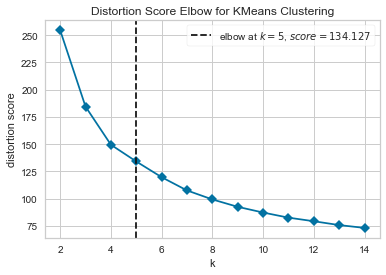

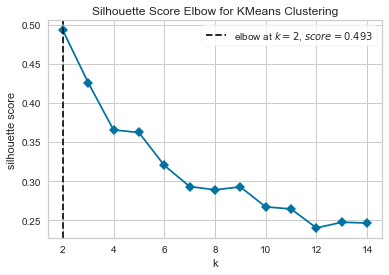

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


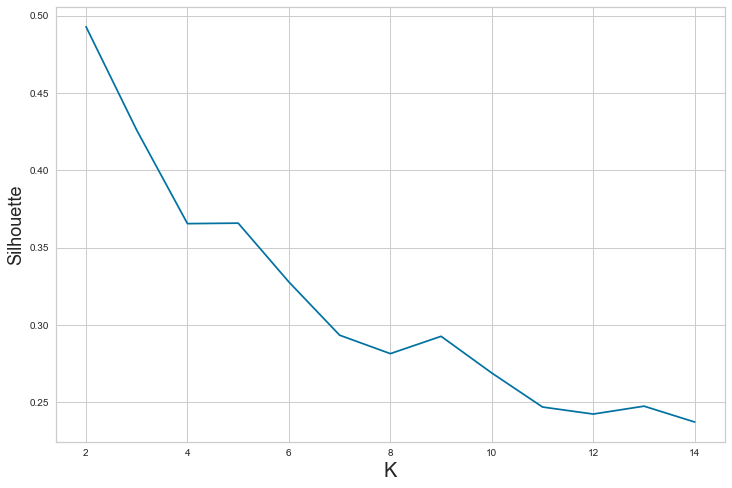

In [17]:
distortions_10=Elbow_Method(ndf_10)
sil_list_10=K_Silhoulette(ndf_10)
Elbow_vis(ndf_10)
Silhoulette_vis(ndf_10)
#plot_elbow(distortions_10)
plot_silhoulette(sil_list_10)

<h2>Analysis of clusters</h2>

In [18]:
k_list=[2,3,4,5]
labels_k=[]
centers_k=[]
cluster_col_k=[]

for i in k_list:
    labels,centers,cluster_col=K_Means(i,ndf_10,df_10,sil_list_10)
    labels_k.append(labels)
    centers_k.append(centers)
    cluster_col_k.append(cluster_col)
    
#labels,centers,cluster_col=K_Means(2,ndf_10,df_10,sil_list_10)

SILHOUETTE: 0.49279831055429973
SILHOUETTE: 0.4259031905896657
SILHOUETTE: 0.3654945798339389
SILHOUETTE: 0.3658153223036289


In [19]:
clust_list_10_k=[]
for i in range(0,len(k_list)):
    data=df_10.copy()
    l = np.transpose(labels_k[i])
    data[cluster_col_k[i]]=l
    clust_list_10=ConvertClusterList(data,cluster_col_k[i])
    clust_list_10_k.append(clust_list_10)
    del data

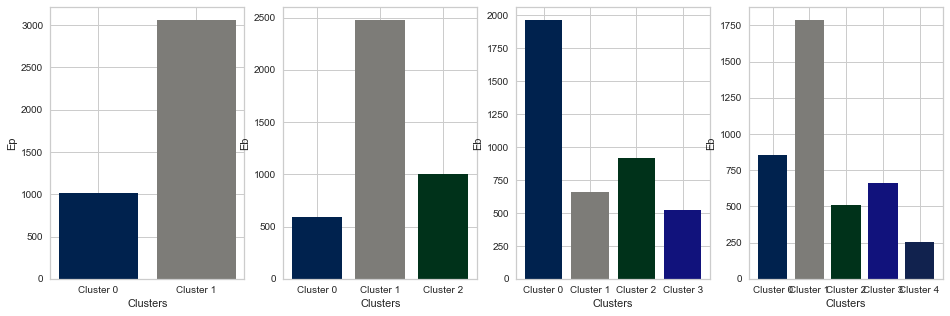

In [32]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

axs[0].bar(['Cluster 0','Cluster 1'], [len(clust_list_10_k[0][0]), len(clust_list_10_k[0][1])], color=['#00224e','#7d7c78'])
axs[0].set_xlabel('Clusters')
axs[0].set_ylabel('Ep')
#axs[0].set_title('Ep of the centroids of the clusters')

axs[1].bar(['Cluster 0','Cluster 1','Cluster 2'], [len(clust_list_10_k[1][0]),len(clust_list_10_k[1][1]),len(clust_list_10_k[1][2])], color=['#00224e','#7d7c78','#00321a'])
axs[1].set_xlabel('Clusters')
axs[1].set_ylabel('Eb')

axs[2].bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3'], [len(clust_list_10_k[2][0]),len(clust_list_10_k[2][1]),len(clust_list_10_k[2][2]),len(clust_list_10_k[2][3])], color=['#00224e','#7d7c78','#00321a','#11127c'])
axs[2].set_xlabel('Clusters')
axs[2].set_ylabel('Eb')

axs[3].bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'], [len(clust_list_10_k[3][0]),len(clust_list_10_k[3][1]),len(clust_list_10_k[3][2]),len(clust_list_10_k[3][3]),len(clust_list_10_k[3][4])], color=['#00224e','#7d7c78','#00321a','#11127c','#11224e'])
axs[3].set_xlabel('Clusters')
axs[3].set_ylabel('Eb')
#axs[1].set_title('Eb of the centroids of the clusters')

#plt.suptitle(("Analysis of the influence of Ep and Eb within the clustering process"),
     #        fontsize=16, fontweight='bold')
plt.show()

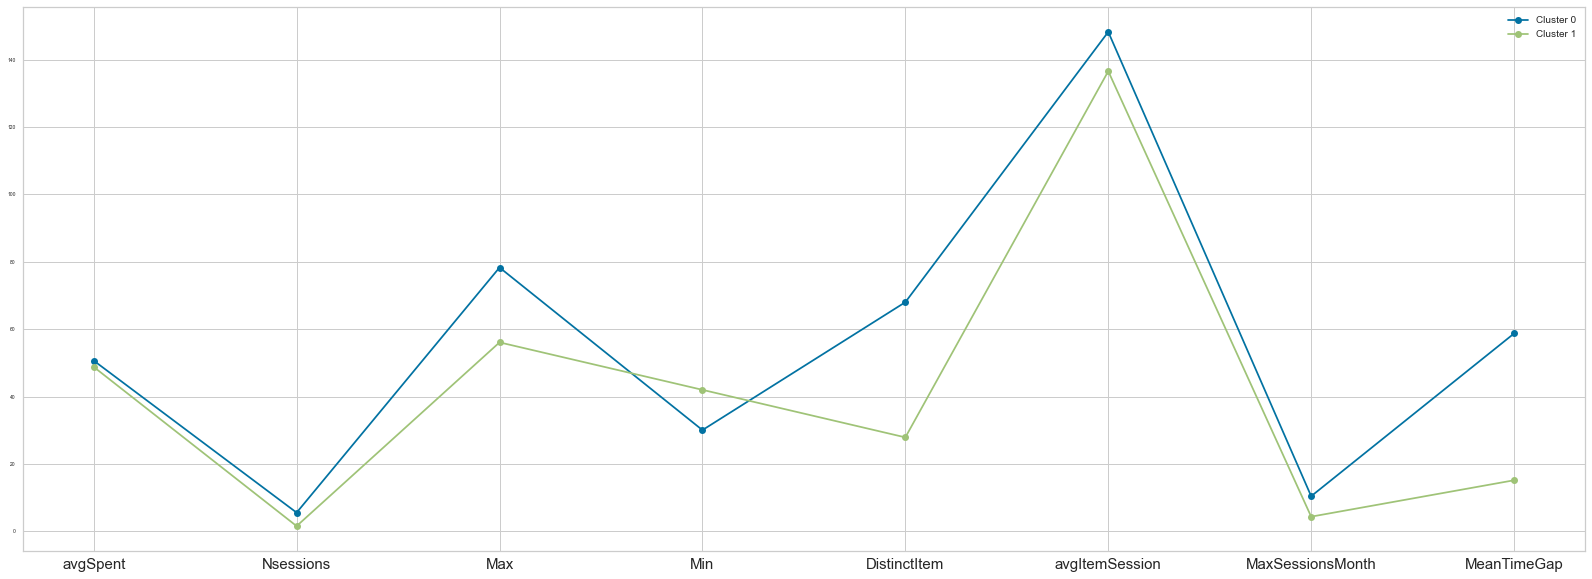

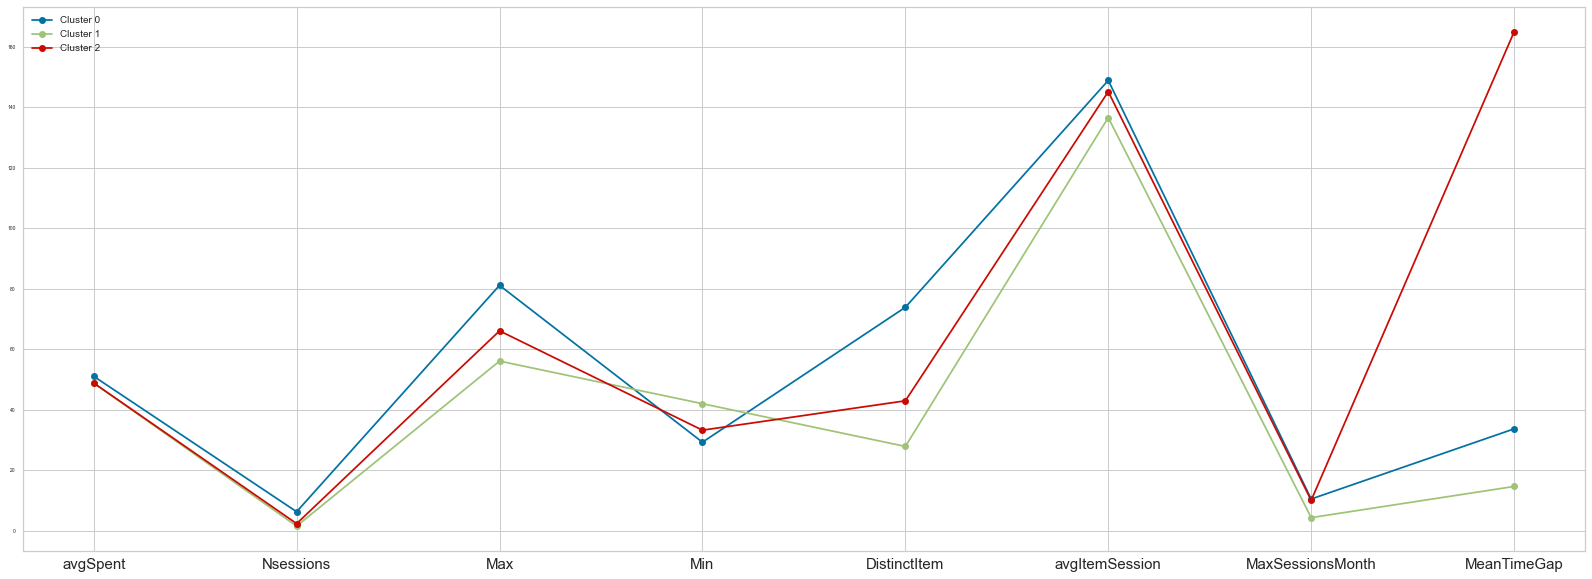

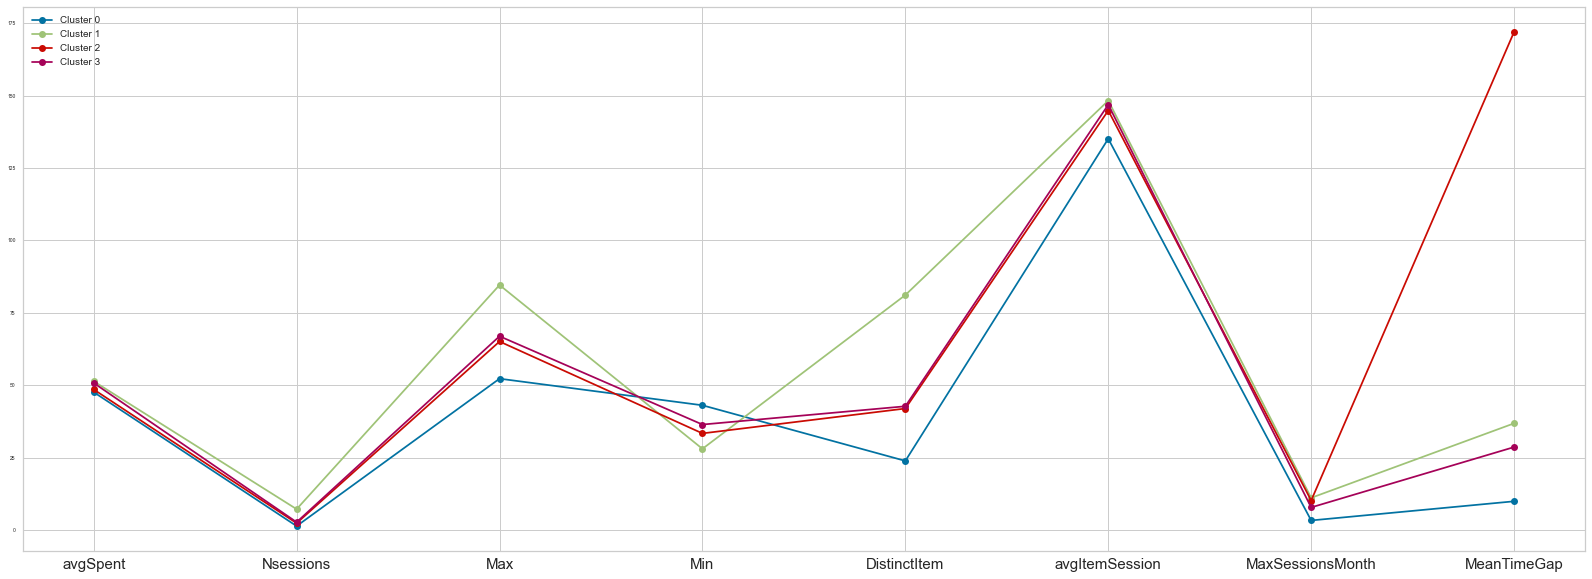

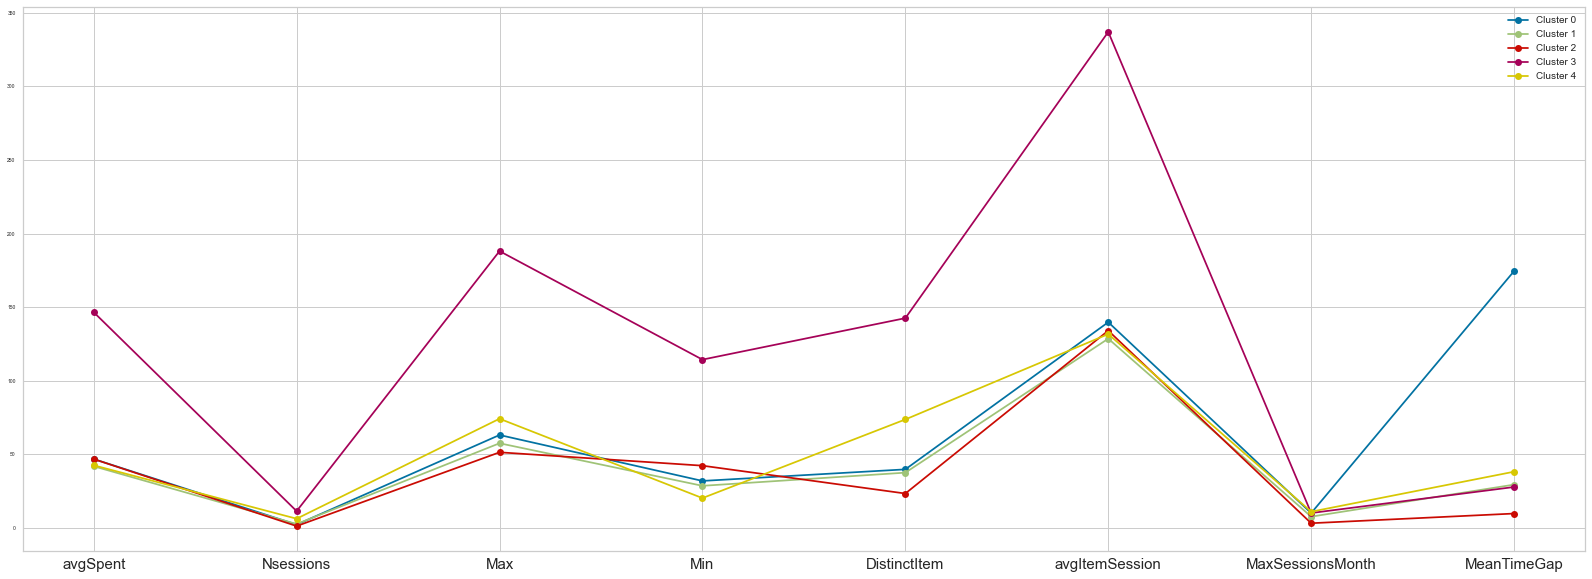

In [27]:
 for i in range(0,len(k_list)):
    plot_parallelCoordinates(centers_k[i],df_10)

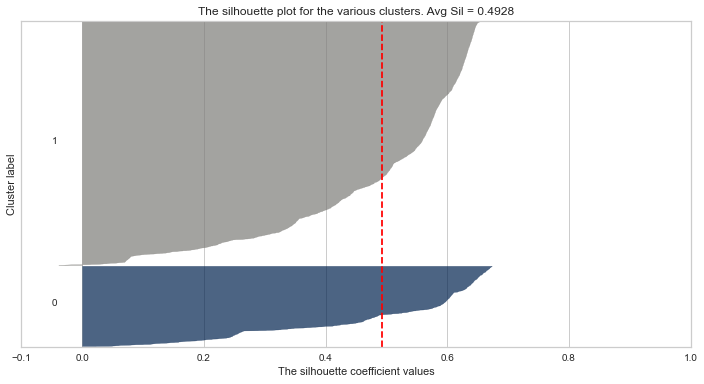

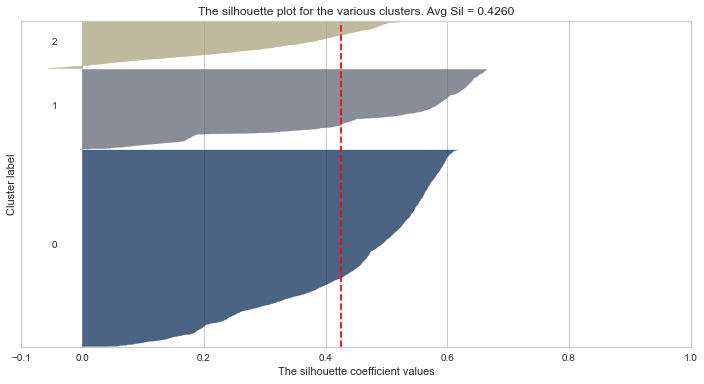

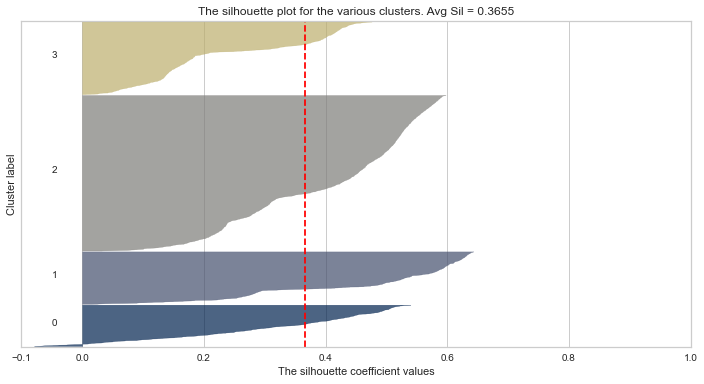

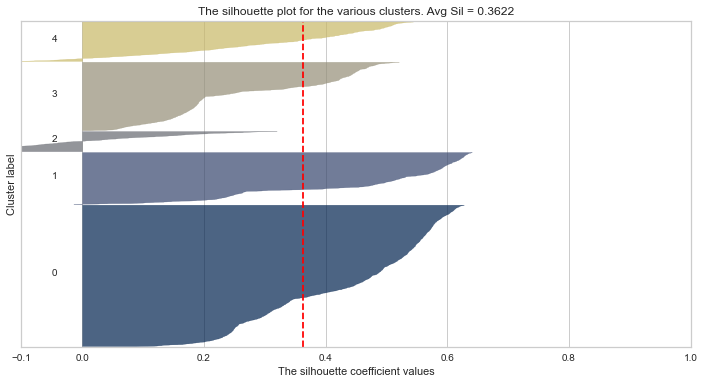

In [42]:
for i in k_list:
    labels_opt=labels_k[i-2]
    [labels_opt]=labels_opt
    plot_silhoulette_clusters(ndf_10,labels_opt,i)

<h3>Visualize cluster using T-SNE</h3>

In [38]:
data = df_10.iloc[:, 0:12]
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(data) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4070 samples in 0.096s...
[t-SNE] Computed neighbors for 4070 samples in 0.336s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4070
[t-SNE] Computed conditional probabilities for sample 2000 / 4070
[t-SNE] Computed conditional probabilities for sample 3000 / 4070
[t-SNE] Computed conditional probabilities for sample 4000 / 4070
[t-SNE] Computed conditional probabilities for sample 4070 / 4070
[t-SNE] Mean sigma: 14.148293
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.304184
[t-SNE] KL divergence after 1000 iterations: 0.851916


[Text(0.5, 1.0, 'Clusters T-SNE projection')]

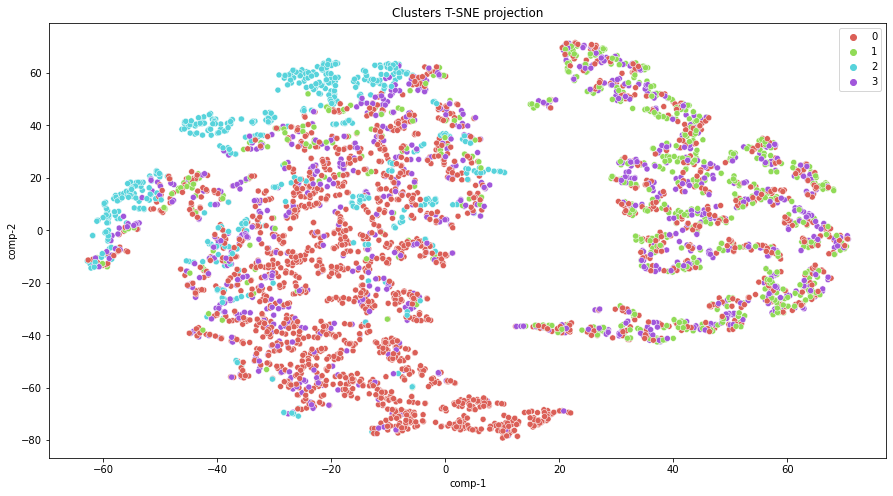

In [42]:
df_tsne = pd.DataFrame()
df_tsne ["target"] = df_10['K_4']
df_tsne["comp-1"] = z[:,0]
df_tsne["comp-2"] = z[:,1]

plt.figure(figsize = (15,8))
sns.scatterplot(x="comp-1", y="comp-2", hue=df_tsne.target.tolist(),palette=sns.color_palette("hls", 4),data=df_tsne).set(title="Clusters T-SNE projection") 

<h2>Dimensionality Reduction using PCA</h2>

In [39]:
customer=df_10

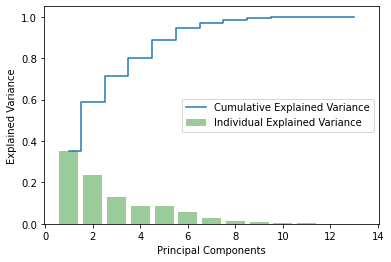

In [40]:
std_customer=plot_ExplaneidVariancePCA(customer)

In [41]:
pca = PCA(n_components=3)
pca_customer = pca.fit_transform(std_customer)

No handles with labels found to put in legend.


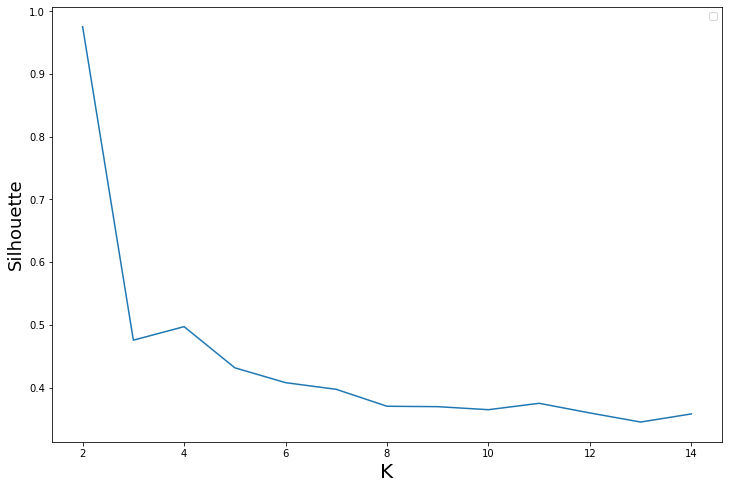

In [43]:
sil_list_pca_10=K_Silhoulette(pca_customer)
plot_silhoulette(sil_list_pca_10)

In [44]:
kmeans = KMeans(n_clusters=4, n_init=100)
clusters_customers = kmeans.fit(pca_customer)

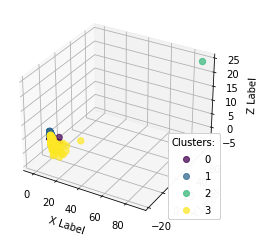

In [45]:
plot_Scatter3D(pca_customer)

In [24]:
cont=0
for i in range(0,len(clusters_customers.labels_)):
    cont=cont+1
    if clusters_customers.labels_[i] == 1:
        break;

In [28]:
df_10.iloc[cont-1]

TotItem             193153.000000
avgSpent               119.429069
Nsessions             2224.000000
TotSpent            265610.250000
Max                   1810.340000
Min                      0.000000
DistinctItem          3331.000000
MaxItem               1964.000000
MinItem                  1.000000
avgItemSession          86.849371
MaxSessionsMonth        12.000000
MeanTimeGap              0.188930
Name: 17841.0, dtype: float64

<h1>Customer 2011</h1>

In [16]:
# Starting dataset
#df_11 = pd.read_csv('dataset/Customer_2011.csv', sep=',', index_col=0)
df_11=pd.read_csv('dataset/Customer_2011.csv', sep=',', index_col=0)

In [17]:
mat = df_11.corr()

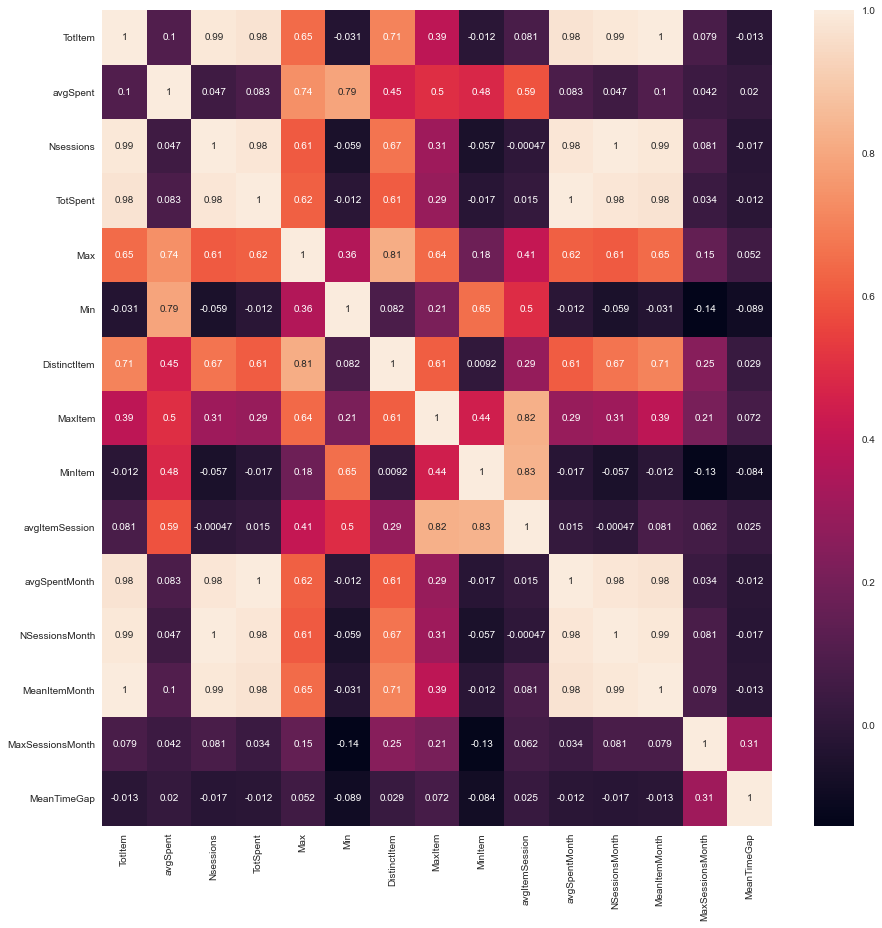

In [18]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(mat, annot=True)
plt.show()

In [19]:
corr_threshold = 0.8
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df_11.columns)):
    for j in range(i+1, len(df_11.columns)):
        corr = df_11[df_11.columns[i]].corr(df_11[df_11.columns[j]])
        if  corr > corr_threshold:
            print(df_11.columns[i] + "\t" + df_11.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
TotItem	Nsessions	0.9868
TotItem	TotSpent	0.9771
TotItem	avgSpentMonth	0.9771
TotItem	NSessionsMonth	0.9868
TotItem	MeanItemMonth	1.0000
Nsessions	TotSpent	0.9843
Nsessions	avgSpentMonth	0.9843
Nsessions	NSessionsMonth	1.0000
Nsessions	MeanItemMonth	0.9868
TotSpent	avgSpentMonth	1.0000
TotSpent	NSessionsMonth	0.9843
TotSpent	MeanItemMonth	0.9771
Max	DistinctItem	0.8135
MaxItem	avgItemSession	0.8225
MinItem	avgItemSession	0.8313
avgSpentMonth	NSessionsMonth	0.9843
avgSpentMonth	MeanItemMonth	0.9771
NSessionsMonth	MeanItemMonth	0.9868


In [24]:
#corr_columns = ['avgSpentMonth','MeanItemMonth','NSessionsMonth']
#corr_columns = ['avgSpentMonth','MeanItemMonth','NSessionsMonth','Min','Max','MaxItem','MinItem','DistinctItem','TotSpent','MeanTimeGap','MaxSessionsMonth'
#               ,'TotItem']
corr_columns = ['TotItem','MeanItemMonth','NSessionsMonth','avgSpentMonth','MaxItem','MinItem','TotSpent']
df_11.drop(corr_columns, axis=1, inplace=True)
df_11.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4082 entries, 12347.0 to 18300.0
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avgSpent          4082 non-null   float64
 1   Nsessions         4082 non-null   int64  
 2   Max               4082 non-null   float64
 3   Min               4082 non-null   float64
 4   DistinctItem      4082 non-null   int64  
 5   avgItemSession    4082 non-null   float64
 6   MaxSessionsMonth  4082 non-null   int64  
 7   MeanTimeGap       4082 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 287.0 KB


In [26]:
df_11.to_csv('dataset/Customer_2011_subset_2.csv')

<h3>Hopkins test</h3>

In [16]:
df_11

,avgSpent,Nsessions,avgItemSession
Customer ID,,,
12347.0,51.731667,6,275.333333
12348.0,0.850000,2,22.000000
12349.0,200.750000,1,547.000000
12350.0,25.300000,1,196.000000
12352.0,30.644286,7,71.714286
...,...,...,...
18281.0,5.460000,1,52.000000
18282.0,11.925000,2,25.500000
18283.0,70.714375,16,84.562500


In [27]:
hopkins(df_11,len(df_11))

0.01192849714930824

<h3>Normalization</h3>

In [28]:
minmax_scaler = MinMaxScaler()
ndf_11=normalization(df_11)

<h2>K Means</h2>

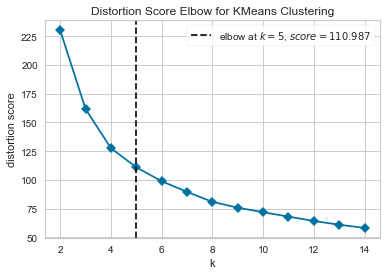

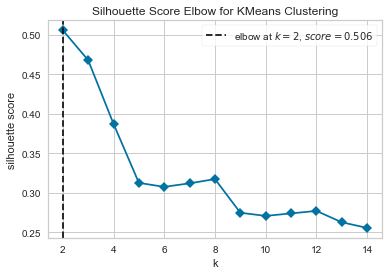

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


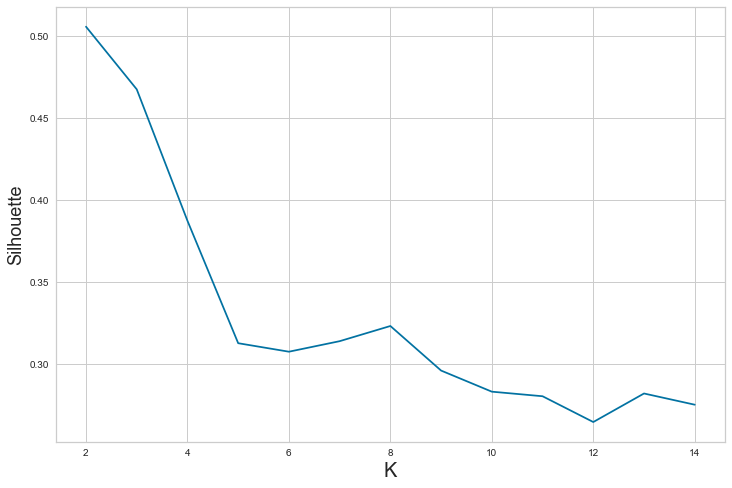

In [29]:
distortions_11=Elbow_Method(ndf_11)
sil_list_11=K_Silhoulette(ndf_11)
Elbow_vis(ndf_11)
Silhoulette_vis(ndf_11)
#plot_elbow(distortions_11)
plot_silhoulette(sil_list_11)

<h2>Analysis of cluster</h2>

In [30]:
k_list=[2,3,4,5]
labels_k=[]
centers_k=[]
cluster_col_k=[]

for i in k_list:
    labels,centers,cluster_col=K_Means(i,ndf_11,df_11,sil_list_11)
    labels_k.append(labels)
    centers_k.append(centers)
    cluster_col_k.append(cluster_col)

SILHOUETTE: 0.5058272451958062
SILHOUETTE: 0.46760754212676436
SILHOUETTE: 0.38736653258884457
SILHOUETTE: 0.3126674097490327


In [31]:
clust_list_11_k=[]
for i in range(0,len(k_list)):
    data=df_11.copy()
    l = np.transpose(labels_k[i])
    data[cluster_col_k[i]]=l
    clust_list_11=ConvertClusterList(data,cluster_col_k[i])
    clust_list_11_k.append(clust_list_11)
    del data

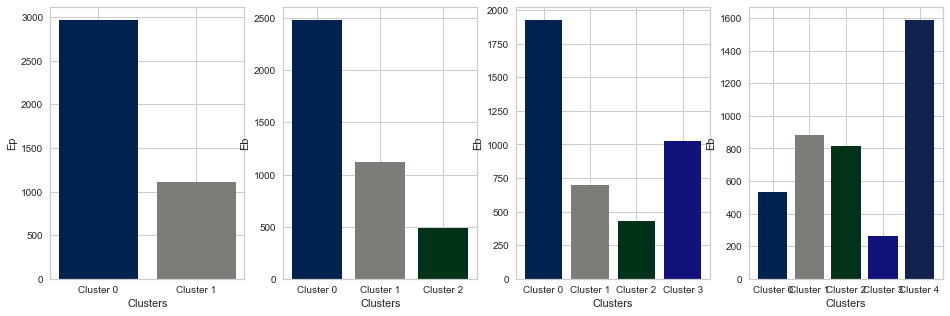

In [32]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

axs[0].bar(['Cluster 0','Cluster 1'], [len(clust_list_11_k[0][0]), len(clust_list_11_k[0][1])], color=['#00224e','#7d7c78'])
axs[0].set_xlabel('Clusters')
axs[0].set_ylabel('Ep')
#axs[0].set_title('Ep of the centroids of the clusters')

axs[1].bar(['Cluster 0','Cluster 1','Cluster 2'], [len(clust_list_11_k[1][0]),len(clust_list_11_k[1][1]),len(clust_list_11_k[1][2])], color=['#00224e','#7d7c78','#00321a'])
axs[1].set_xlabel('Clusters')
axs[1].set_ylabel('Eb')

axs[2].bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3'], [len(clust_list_11_k[2][0]),len(clust_list_11_k[2][1]),len(clust_list_11_k[2][2]),len(clust_list_11_k[2][3])], color=['#00224e','#7d7c78','#00321a','#11127c'])
axs[2].set_xlabel('Clusters')
axs[2].set_ylabel('Eb')

axs[3].bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'], [len(clust_list_11_k[3][0]),len(clust_list_11_k[3][1]),len(clust_list_11_k[3][2]),len(clust_list_11_k[3][3]),len(clust_list_11_k[3][4])], color=['#00224e','#7d7c78','#00321a','#11127c','#11224e'])
axs[3].set_xlabel('Clusters')
axs[3].set_ylabel('Eb')
#axs[1].set_title('Eb of the centroids of the clusters')

#plt.suptitle(("Analysis of the influence of Ep and Eb within the clustering process"),
     #        fontsize=16, fontweight='bold')
plt.show()

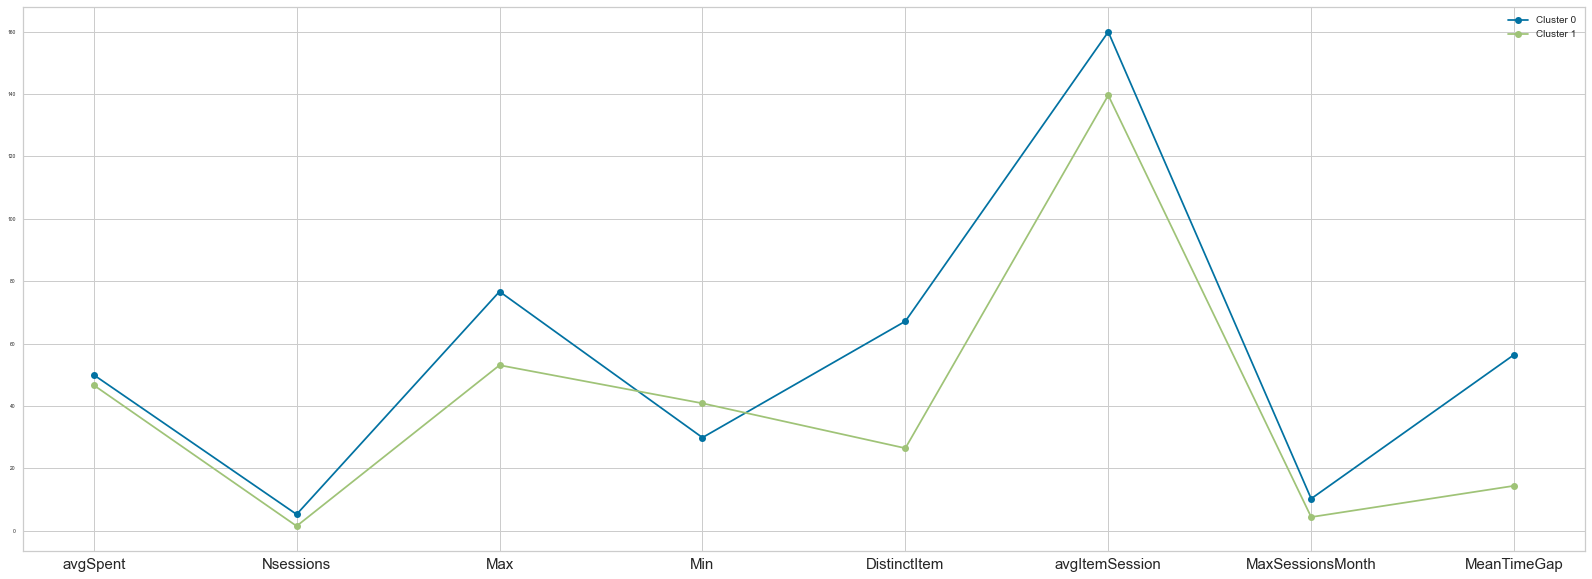

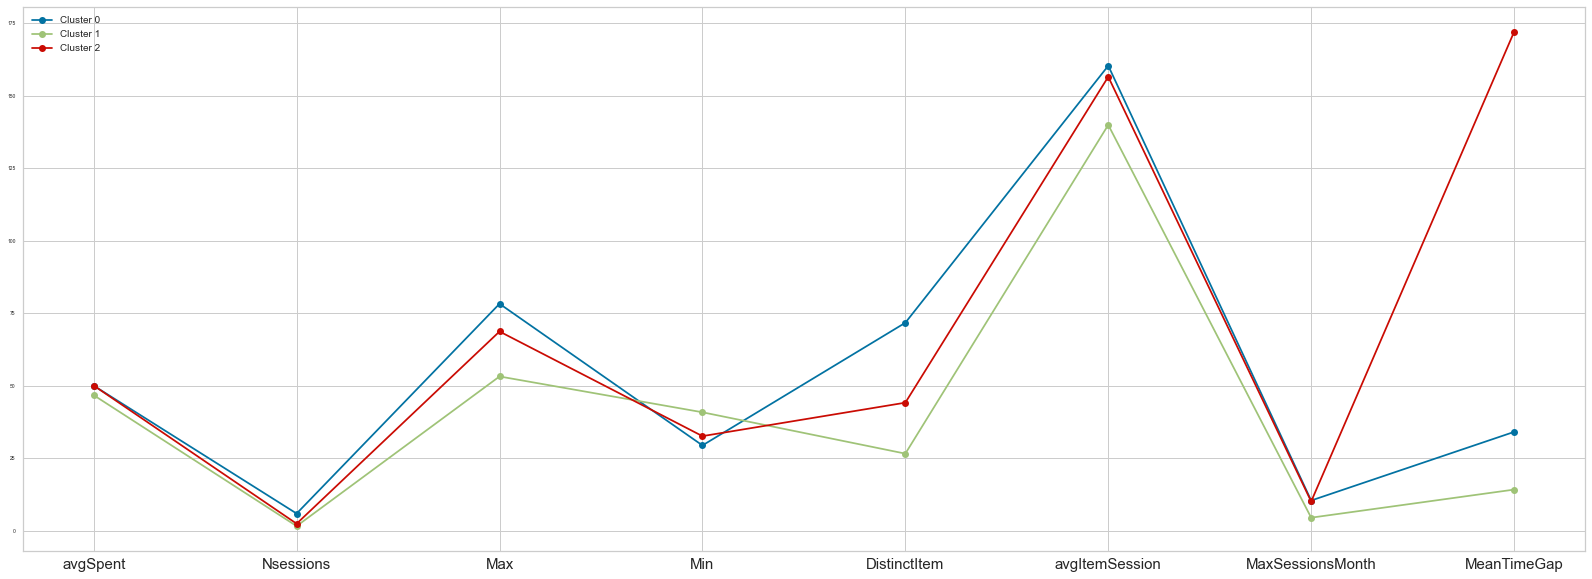

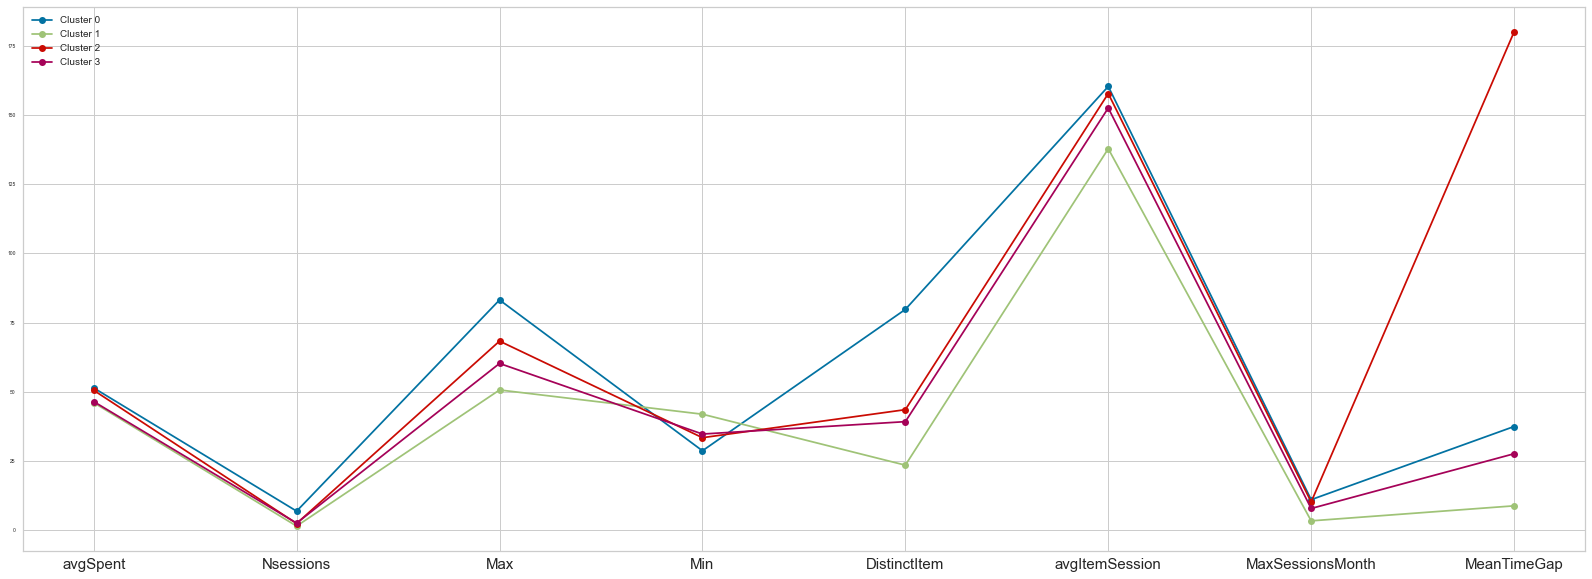

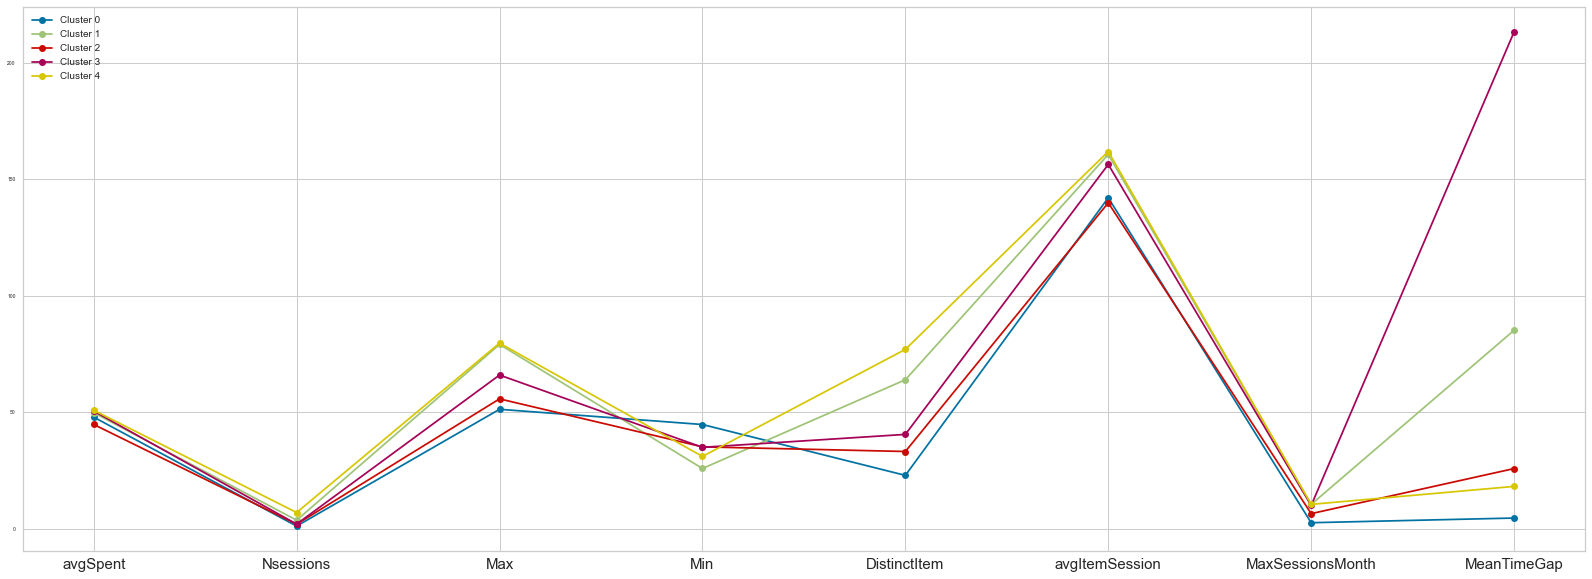

In [33]:
 for i in range(0,len(k_list)):
    plot_parallelCoordinates(centers_k[i],df_11)

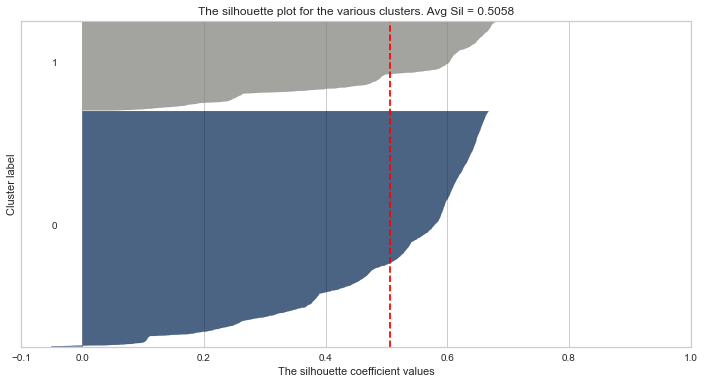

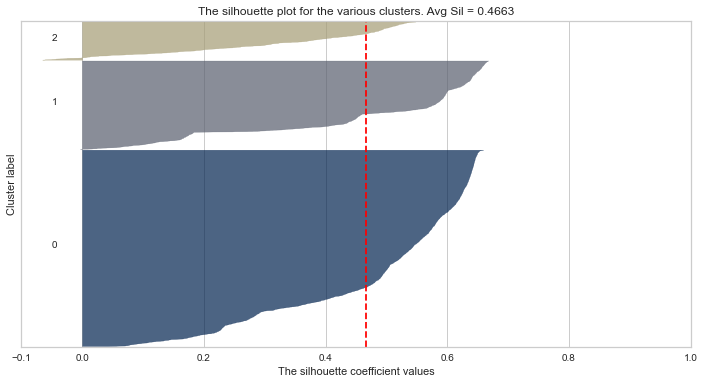

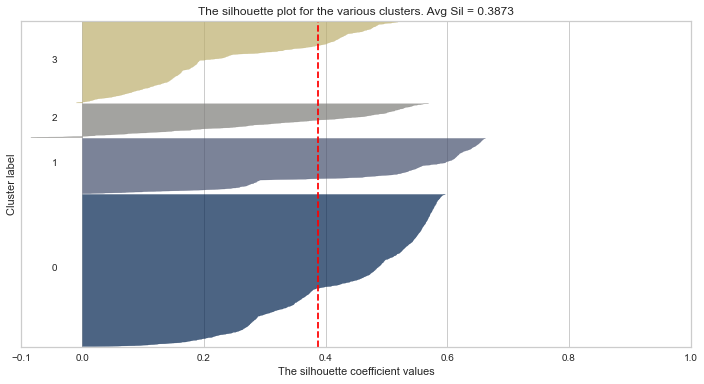

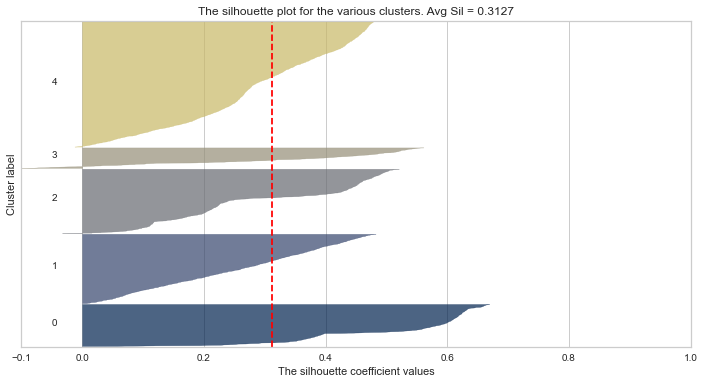

In [34]:
for i in k_list:
    labels_opt=labels_k[i-2]
    [labels_opt]=labels_opt
    plot_silhoulette_clusters(ndf_11,labels_opt,i)

<h2>Dimensionality Reduction using PCA</h2>

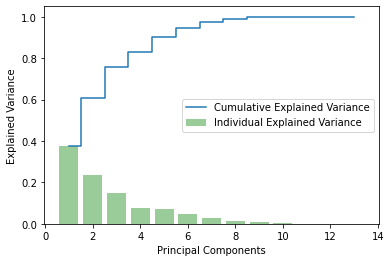

In [54]:
customer=df_11
std_customer=plot_ExplaneidVariancePCA(customer)

In [55]:
pca = PCA(n_components=3)
pca_customer = pca.fit_transform(std_customer)

No handles with labels found to put in legend.


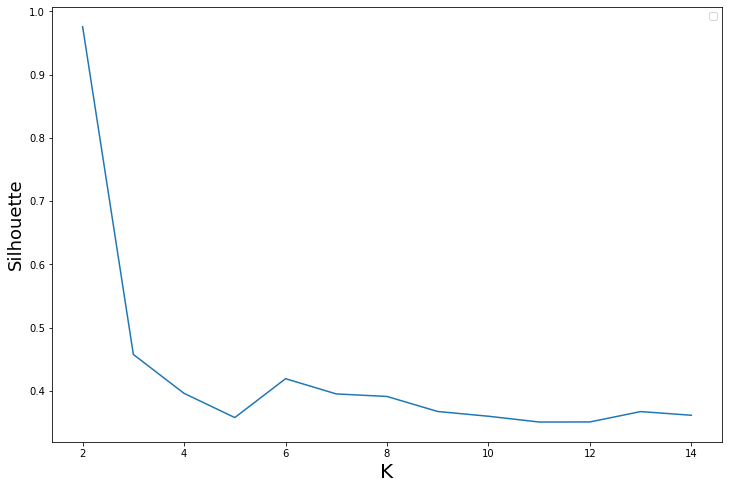

In [56]:
sil_list_11_pca=K_Silhoulette(pca_customer)
plot_silhoulette(sil_list_11_pca)

In [57]:
kmeans = KMeans(n_clusters=4, n_init=100)
clusters_customers = kmeans.fit(pca_customer)

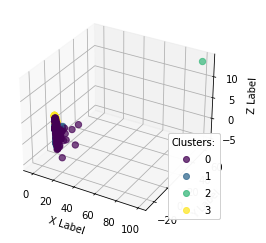

In [58]:
plot_Scatter3D(pca_customer)

In [22]:
cont=0
for i in range(0,len(clusters_customers.labels_)):
    if clusters_customers.labels_[i] == 1:
        break;
    cont=cont+1
    
df_11.iloc[cont]

TotItem             283153.000000
avgSpent               193.181417
Nsessions             1778.000000
TotSpent            343476.560000
Max                   3177.140000
Min                      0.000000
DistinctItem          3214.000000
MaxItem               3765.000000
MinItem                  1.000000
avgItemSession         159.253656
MaxSessionsMonth        12.000000
MeanTimeGap              0.214555
K_4                      2.000000
Name: 17841.0, dtype: float64

<p>We decide to drop the customer 17841 in all clusters because is an clustering anomaly that has a very high magnitude in the attributes. This we could see from the PCA analysis that only one data beloging to only one cluster.
</p>

In [4]:
df.reset_index(inplace=True)

In [6]:
new_df_09=df[df['Customer ID']!=17841]

In [12]:
df_10.reset_index(inplace=True)
new_df_10=df_10[df_10['Customer ID']!=17841]

In [14]:
df_11.reset_index(inplace=True)
new_df_11=df_11[df_11['Customer ID']!=17841]

In [15]:
new_df_09.to_csv(r'C:\Users\Stefano\Desktop\Data-Mining-Project\dataset\new_Customer_2009.csv', index = False, header=True)
new_df_10.to_csv(r'C:\Users\Stefano\Desktop\Data-Mining-Project\dataset\new_Customer_2010.csv', index = False, header=True)
new_df_11.to_csv(r'C:\Users\Stefano\Desktop\Data-Mining-Project\dataset\new_Customer_2011.csv', index = False, header=True)

<h1>Customer 2009</h1>

In [15]:
# Starting dataset
df_09 = pd.read_csv('dataset/new_Customer_2009.csv', sep=',', index_col=0)

In [16]:
minmax_scaler = MinMaxScaler()
ndf_09=normalization(df_09)

No handles with labels found to put in legend.


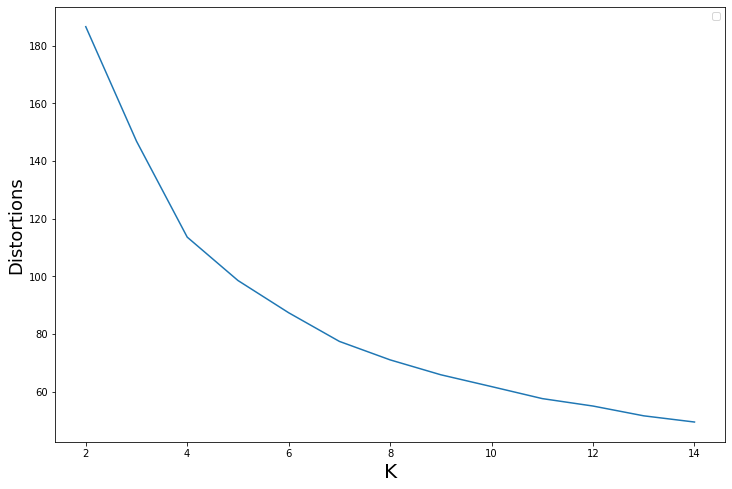

In [19]:
distortions=Elbow_Method(ndf_09)
plot_elbow(distortions)

No handles with labels found to put in legend.


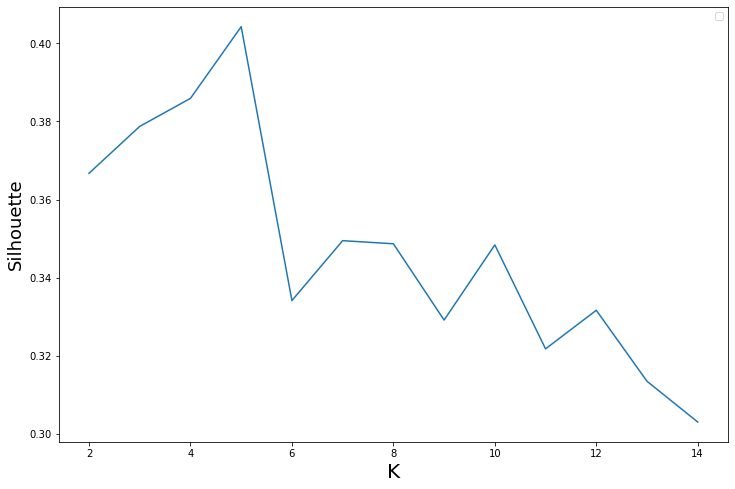

In [17]:
sil_list_09=K_Silhoulette(ndf_09)
plot_silhoulette(sil_list_09)

In [20]:
#Copy the dataset for PCA
customer=df_09

In [18]:
labels_04,centers_04,cluster_col_04=K_Means(4,ndf_09,df_09,sil_list_09)

SILHOUETTE: 0.38590833933916857


In [19]:
labels_03,centers_03,cluster_col_03=K_Means(3,ndf_09,df_09,sil_list_09)

SILHOUETTE: 0.37874013170805076


In [20]:
clust_list_09_4=ConvertClusterList(df_09,cluster_col_04)

In [22]:
clust_list_09_3=ConvertClusterList(df_09,cluster_col_03)

<BarContainer object of 4 artists>

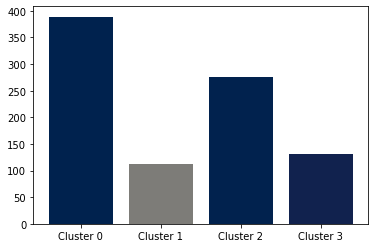

In [23]:
plt.bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3'], [len(clust_list_09_4[0]), len(clust_list_09_4[1]),len(clust_list_09_4[2]),len(clust_list_09_4[3])], color=['#00224e','#7d7c78','#01224e','#11224e'])

<BarContainer object of 3 artists>

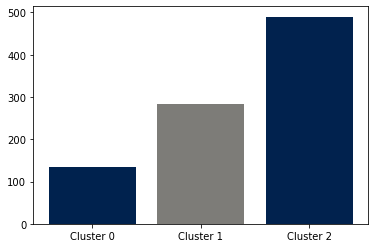

In [24]:
plt.bar(['Cluster 0','Cluster 1','Cluster 2'], [len(clust_list_09_3[0]), len(clust_list_09_3[1]),len(clust_list_09_3[2])], color=['#00224e','#7d7c78','#01224e','#11224e'])

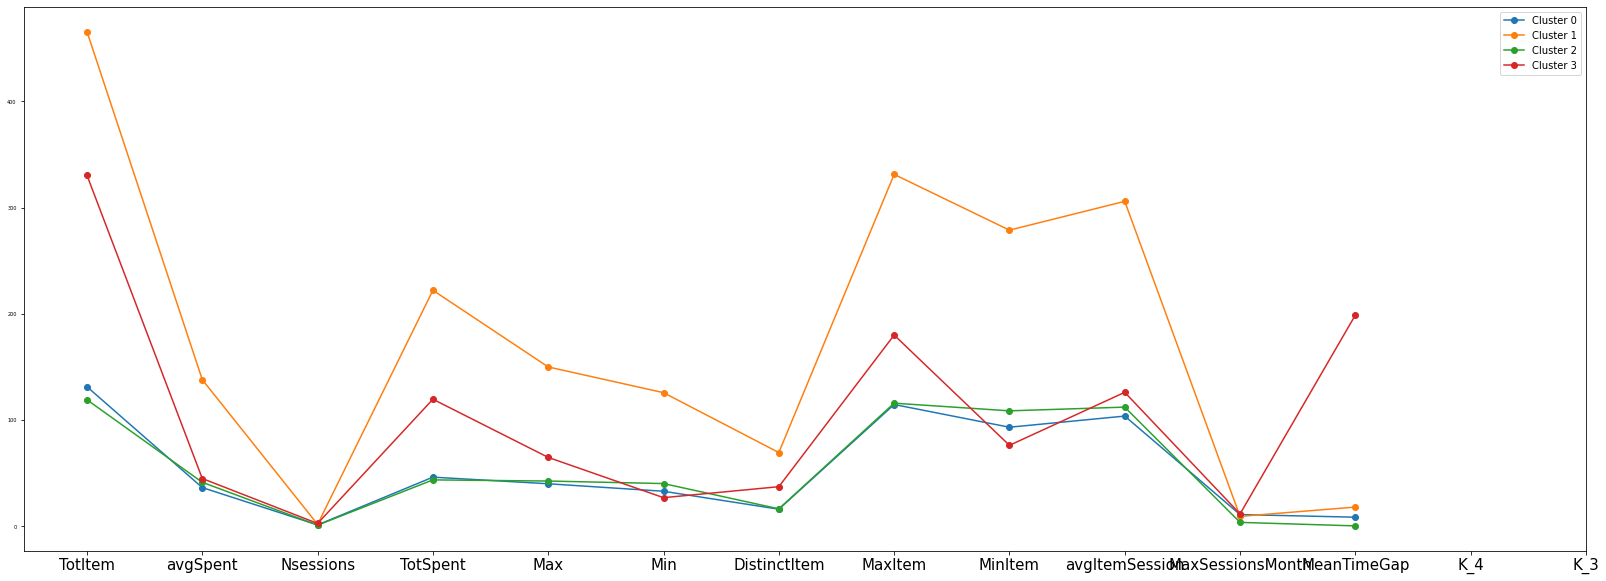

In [25]:
 plot_parallelCoordinates(centers_04,df_09)

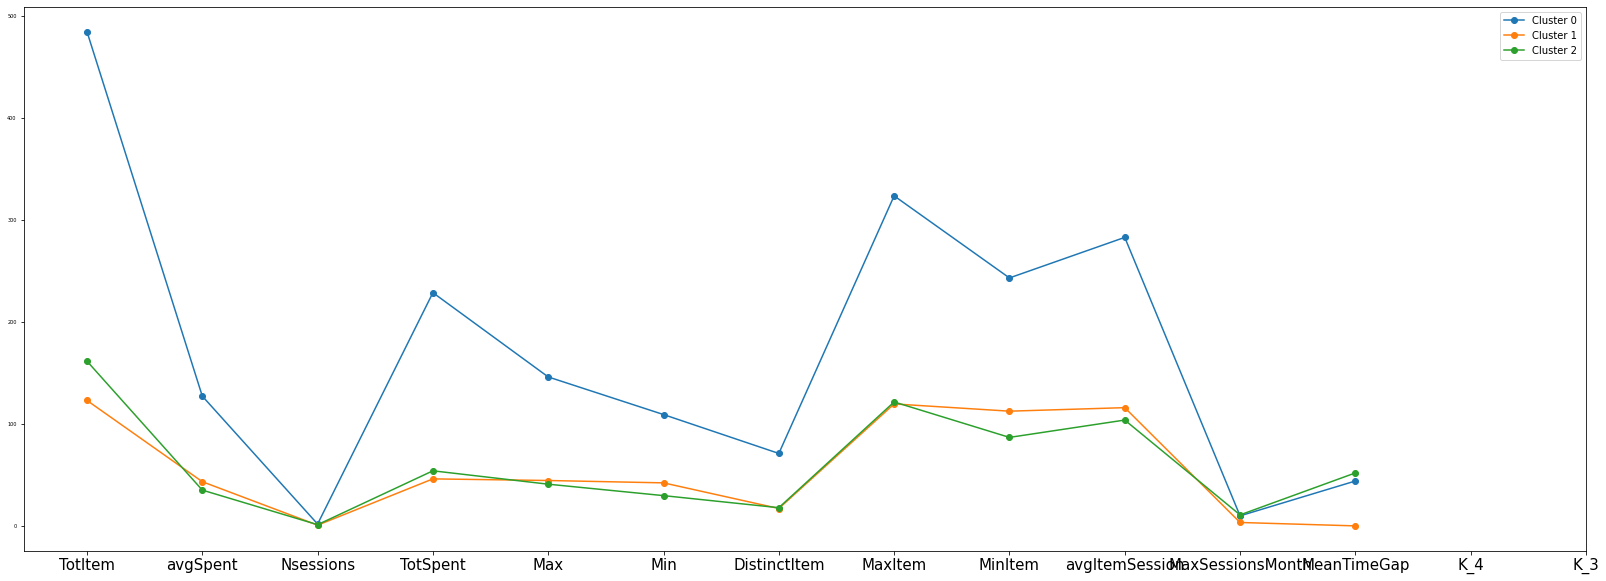

In [26]:
 plot_parallelCoordinates(centers_03,df_09)

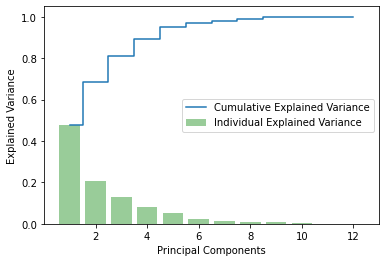

In [22]:
#customer=df_09
std_customer=plot_ExplaneidVariancePCA(customer)

In [23]:
pca = PCA(n_components=3)
pca_customer = pca.fit_transform(std_customer)

No handles with labels found to put in legend.


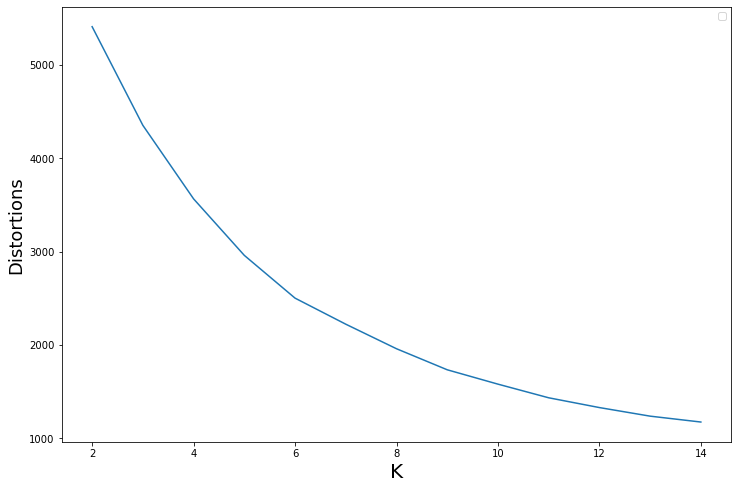

In [24]:
distortions_pca=Elbow_Method(pca_customer)
plot_elbow(distortions_pca)

No handles with labels found to put in legend.


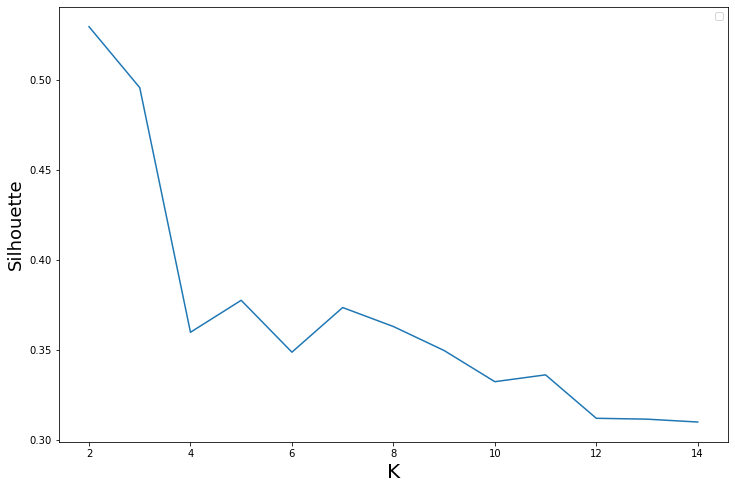

In [14]:
sil_list_09_pca=K_Silhoulette(pca_customer)
plot_silhoulette(sil_list_09_pca)

In [15]:
kmeans = KMeans(n_clusters=4, n_init=100)
clusters_customers = kmeans.fit(pca_customer)

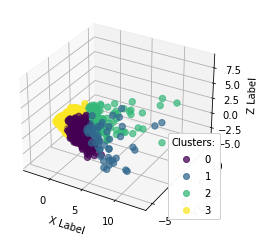

In [16]:
plot_Scatter3D(pca_customer)

<h1>Customer 2010</h1>

In [25]:
# Starting dataset
df_10 = pd.read_csv('dataset/new_Customer_2010.csv', sep=',', index_col=0)

In [27]:
minmax_scaler = MinMaxScaler()
ndf_10=normalization(df_10)

No handles with labels found to put in legend.


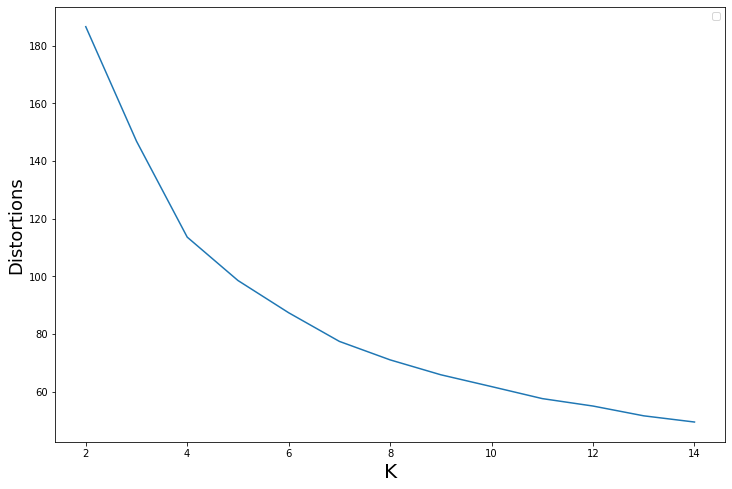

In [28]:
distortions_10=Elbow_Method(ndf_10)
plot_elbow(distortions)

No handles with labels found to put in legend.


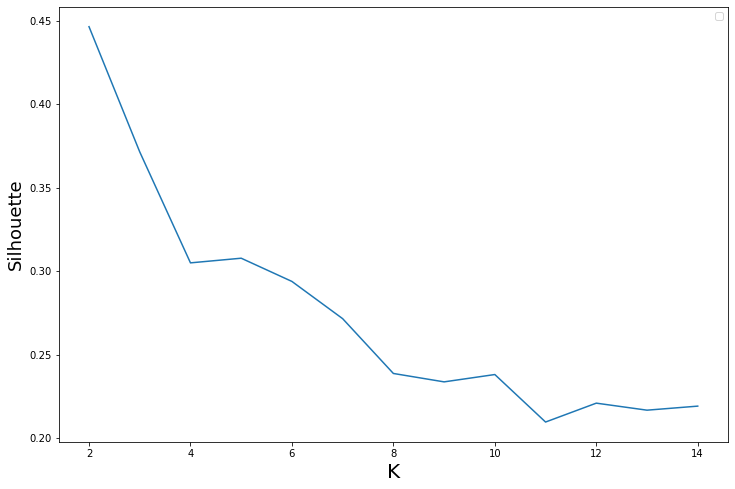

In [29]:
sil_list_10=K_Silhoulette(ndf_10)
plot_silhoulette(sil_list_10)

In [30]:
labels,centers,cluster_col=K_Means(4,ndf_10,df_10,sil_list_10)
clust_list_10=ConvertClusterList(df_10,cluster_col)

SILHOUETTE: 0.30489277223676037


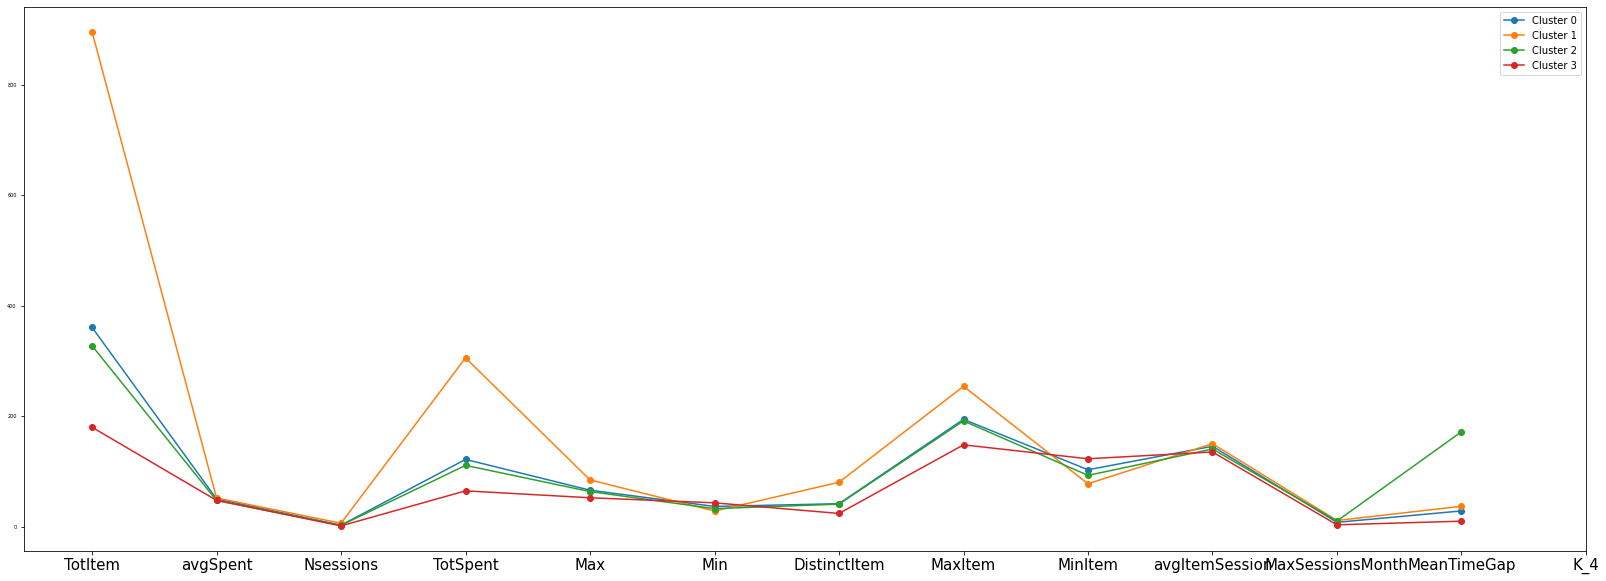

In [31]:
plot_parallelCoordinates(centers,df_10)

<h1>Customer 2011</h1>

In [32]:
df_11 = pd.read_csv('dataset/new_Customer_2011.csv', sep=',', index_col=0)

In [35]:
minmax_scaler = MinMaxScaler()
ndf_11=normalization(df_11)

No handles with labels found to put in legend.


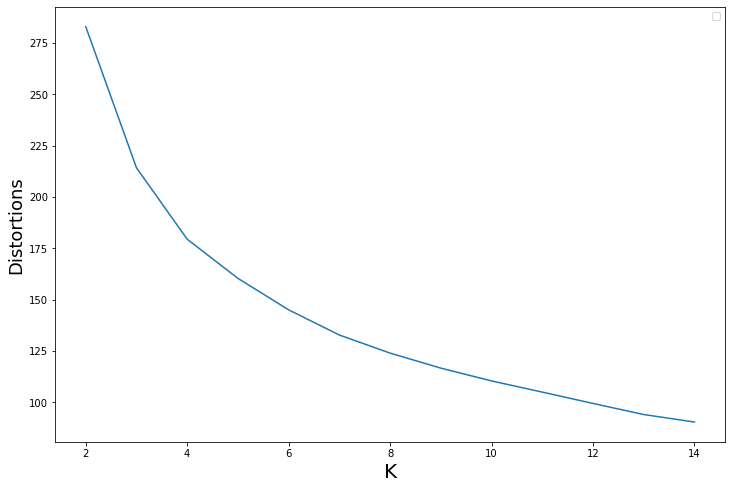

In [36]:
distortions_11=Elbow_Method(ndf_11)
plot_elbow(distortions_11)

No handles with labels found to put in legend.


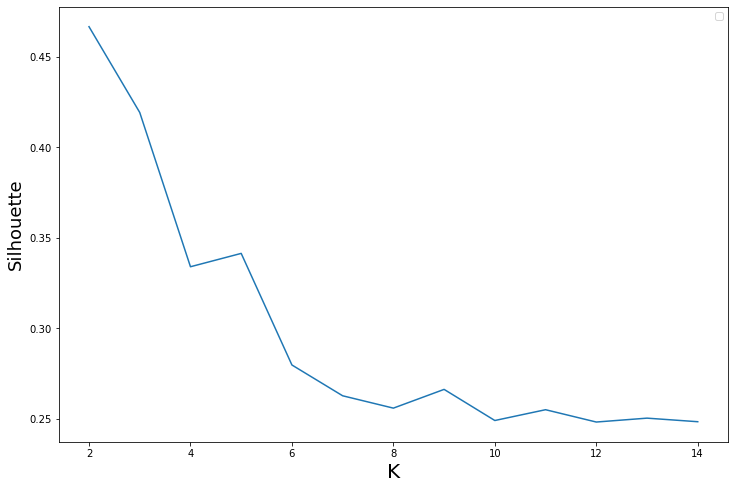

In [37]:
sil_list_11=K_Silhoulette(ndf_11)
plot_silhoulette(sil_list_11)